# Guillaume Payeur (260929164)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import interpolate
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rcParams.update({"text.usetex": True})
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import time
import corner

In [3]:
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at C:\Users\Guill\Anaconda3\envs\comp_phys\lib\site-packages\camb


# Q1

I begin by running the test script

In [4]:
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]

chisq is  15267.937150261656  for  2501  degrees of freedom.


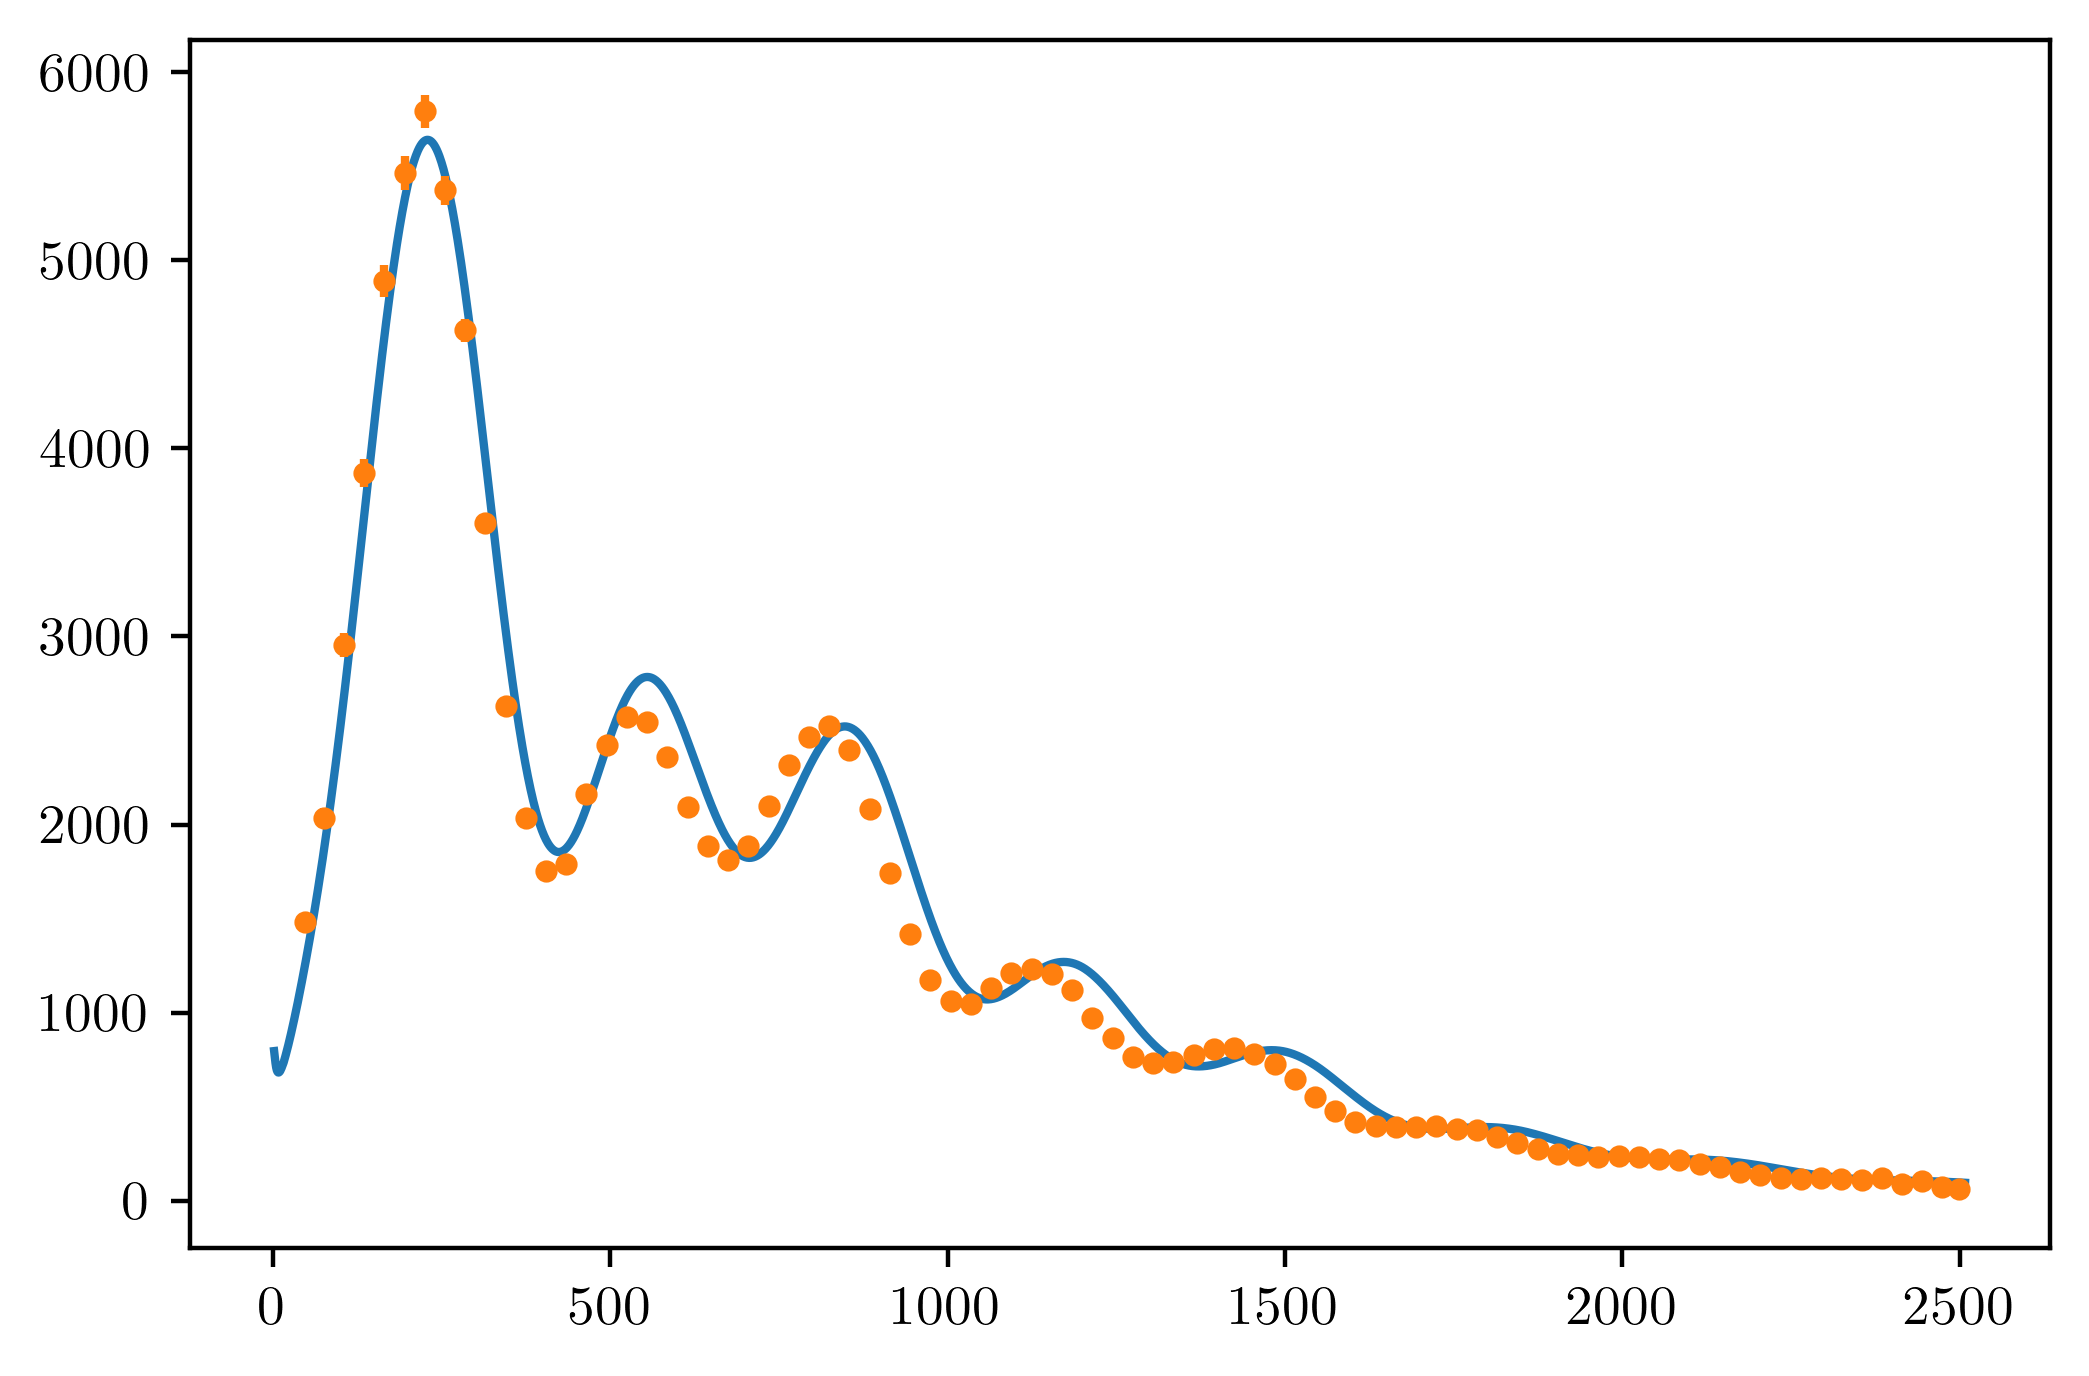

In [5]:
pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

The $\chi^2$ is 15267 which is much more than $\sqrt{2n}$, where $n$ is the number of DOF, meaning the fit is not acceptable.

Now I run the code again with parameters equal to [69,0.022,0.12,0.06,2.1e-9,0.95]

chisq is  3272.2053559202204  for  2501  degrees of freedom.


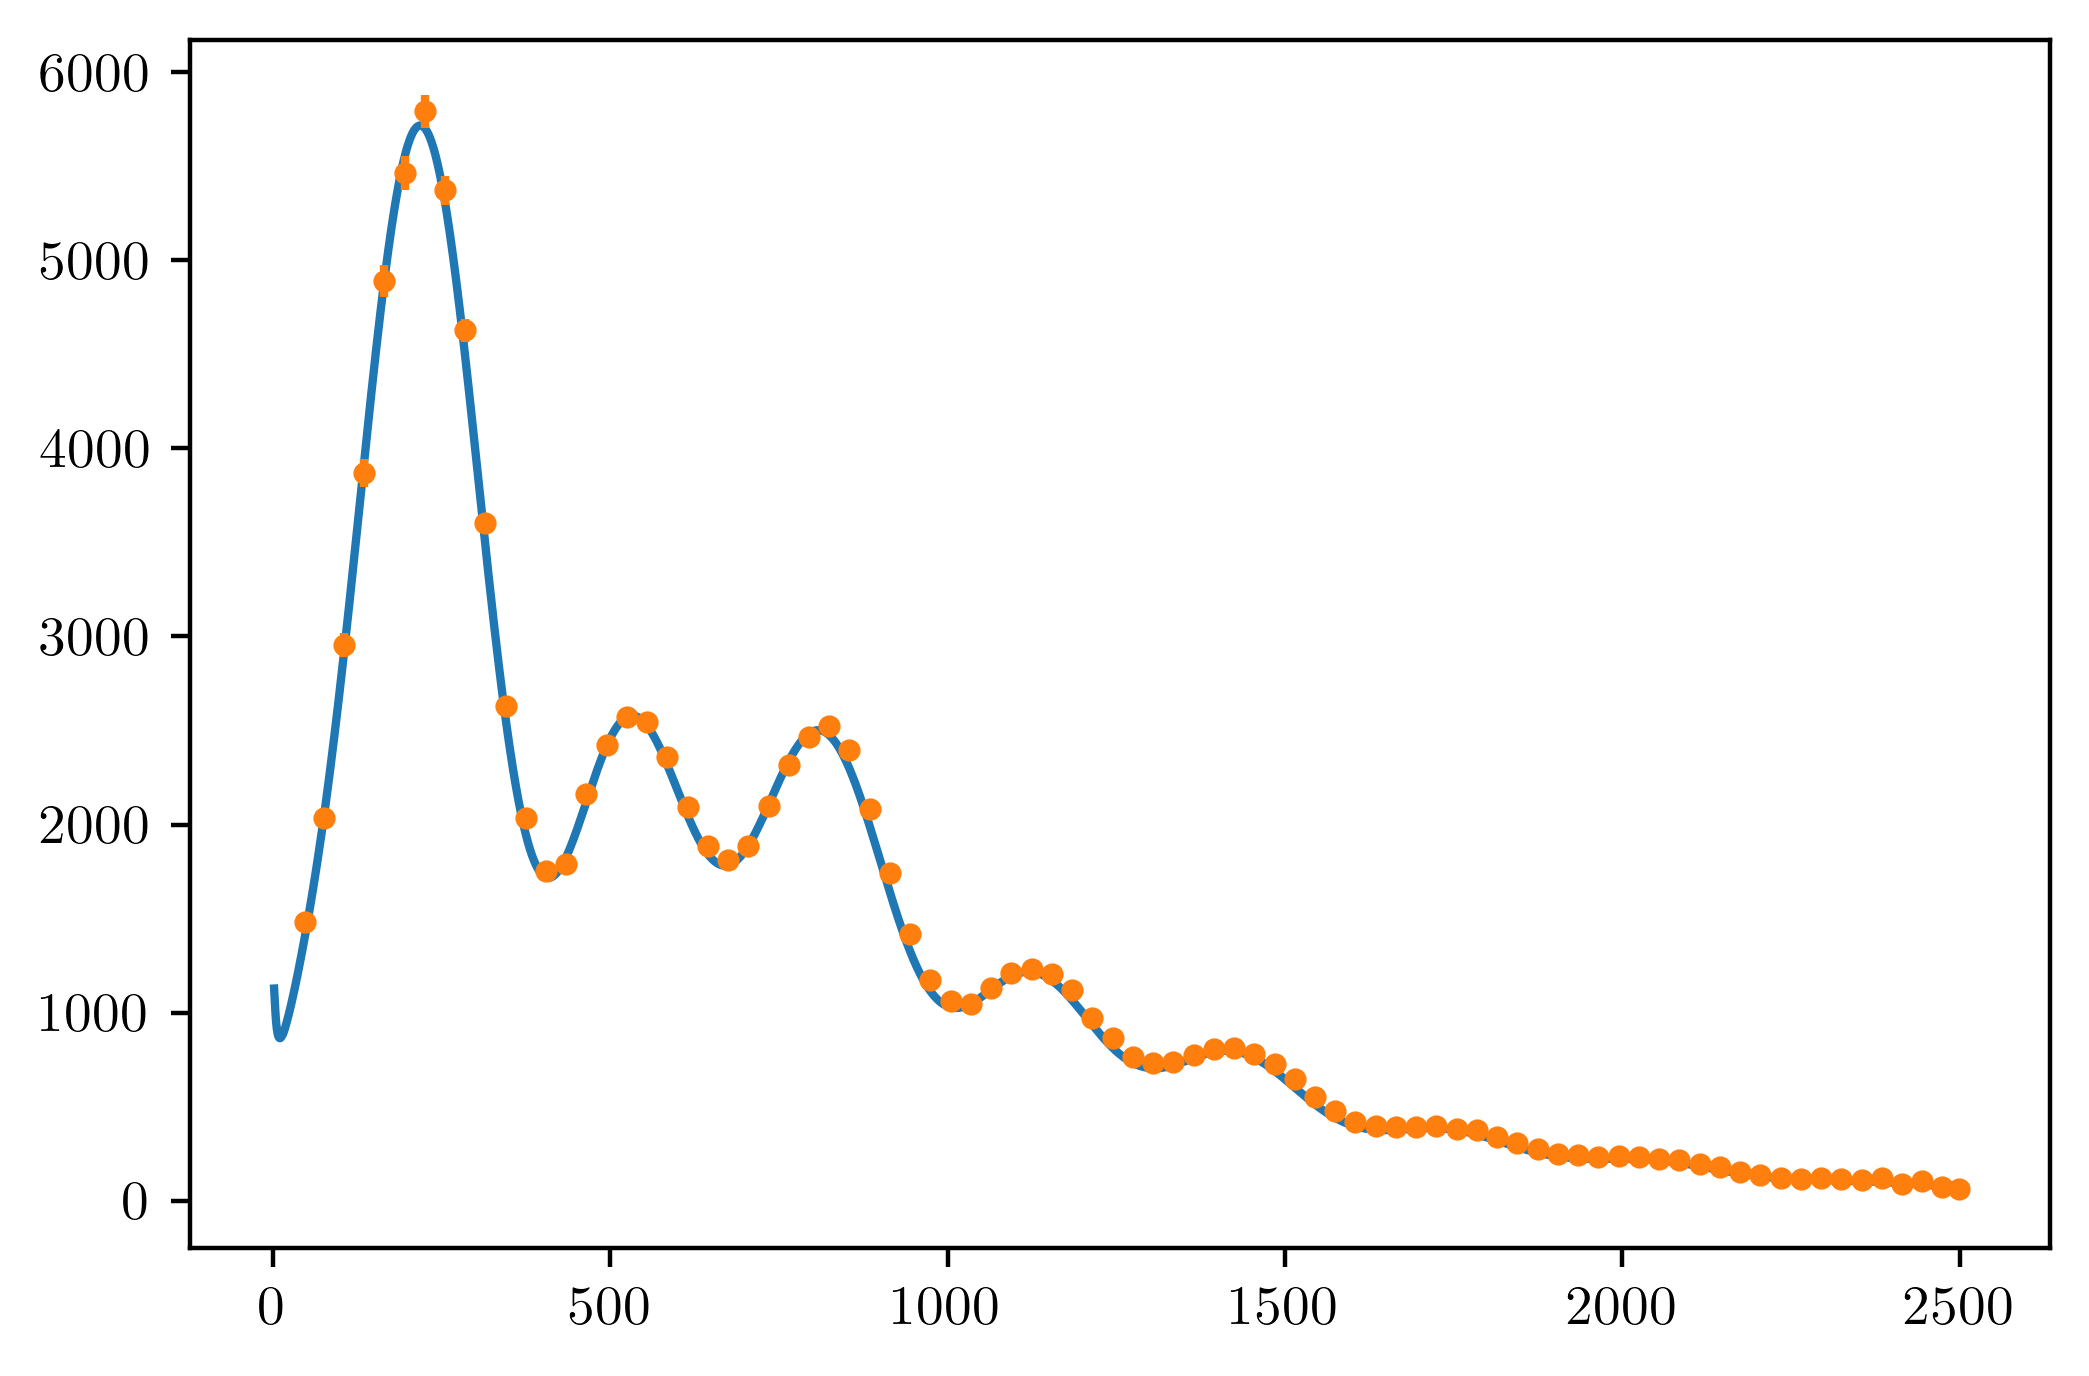

In [6]:
pars=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

The $\chi^2$ is 3272 which is within on standard deviation ($\sqrt{2n}$) of the mean ($n$) of the $\chi^2$ distribution, meaning the fit is acceptable.

# Q2

Now we use Newton's method to find the least squares parameters.

In [7]:
from scipy.misc import derivative

def ndiff(fun,x):
    delta = 1e-8    
    # Calculating derivative
    f1 = 1/(2*delta)*(fun(x+delta)-fun(x-delta))
    return f1

# Initial guess for parameters
m=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])

# Doing itterations of Newton's method
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
for i in range(10):
    # Computing residuals
    errs=0.5*(planck[:,2]+planck[:,3]);
    model=get_spectrum(m)
    model=model[:len(spec)]
    resid=spec-model

    # Computing gradient of A numerically
    def fun_H0(H0):
        pars = np.concatenate((np.array([H0]),m[1:6]))
        model=get_spectrum(pars)[:len(spec)]
        return model
    A_H0 = ndiff(fun_H0,m[0])
    
    def fun_Omega_b(Omega_b):
        pars = np.concatenate((m[0:1],np.array([Omega_b]),m[2:6]))
        model=get_spectrum(pars)[:len(spec)]
        return model
    A_Omega_b = ndiff(fun_Omega_b,m[1])
    
    def fun_Omega_c(Omega_c):
        pars = np.concatenate((m[0:2],np.array([Omega_c]),m[3:6]))
        model=get_spectrum(pars)[:len(spec)]
        return model
    A_Omega_c = ndiff(fun_Omega_c,m[2])

    def fun_tau(tau):
        pars = np.concatenate((m[0:3],np.array([tau]),m[4:6]))
        model=get_spectrum(pars)[:len(spec)]
        return model
    A_tau = ndiff(fun_tau,m[3])
    
    def fun_A_s(A_s):
        pars = np.concatenate((m[0:4],np.array([A_s]),m[5:6]))
        model=get_spectrum(pars)[:len(spec)]
        return model
    A_A_s = ndiff(fun_A_s,m[4])
    
    def fun_n_s(n_s):
        pars = np.concatenate((m[0:5],np.array([n_s])))
        model=get_spectrum(pars)[:len(spec)]
        return model
    A_n_s = ndiff(fun_n_s,m[5])
      
    A_m = np.zeros((model.shape[0],6))
    A_m[:,0] = A_H0
    A_m[:,1] = A_Omega_b
    A_m[:,2] = A_Omega_c
    A_m[:,3] = A_tau
    A_m[:,4] = A_A_s*0
    A_m[:,5] = A_n_s
               
    # Computing delta m
    delta_m = np.linalg.pinv(A_m.T@A_m)@A_m.T@resid
    m = m + delta_m
    
    A_m = np.zeros((model.shape[0],6))
    A_m[:,0] = A_H0
    A_m[:,1] = A_Omega_b
    A_m[:,2] = A_Omega_c
    A_m[:,3] = A_tau
    A_m[:,4] = A_A_s
    A_m[:,5] = A_n_s
               
    # Computing delta m
    delta_m = np.linalg.pinv(A_m.T@A_m)@A_m.T@resid
    m = m + delta_m
    
# Printing best fit parameters
print(m)

[6.91971714e+01 2.26039287e-02 1.15653570e-01 6.32423042e-02
 2.09951316e-09 9.76966890e-01]


Plotting the model and the data to make sure the parameters are good

chisq is  2602.4486419544246  for  2501  degrees of freedom.


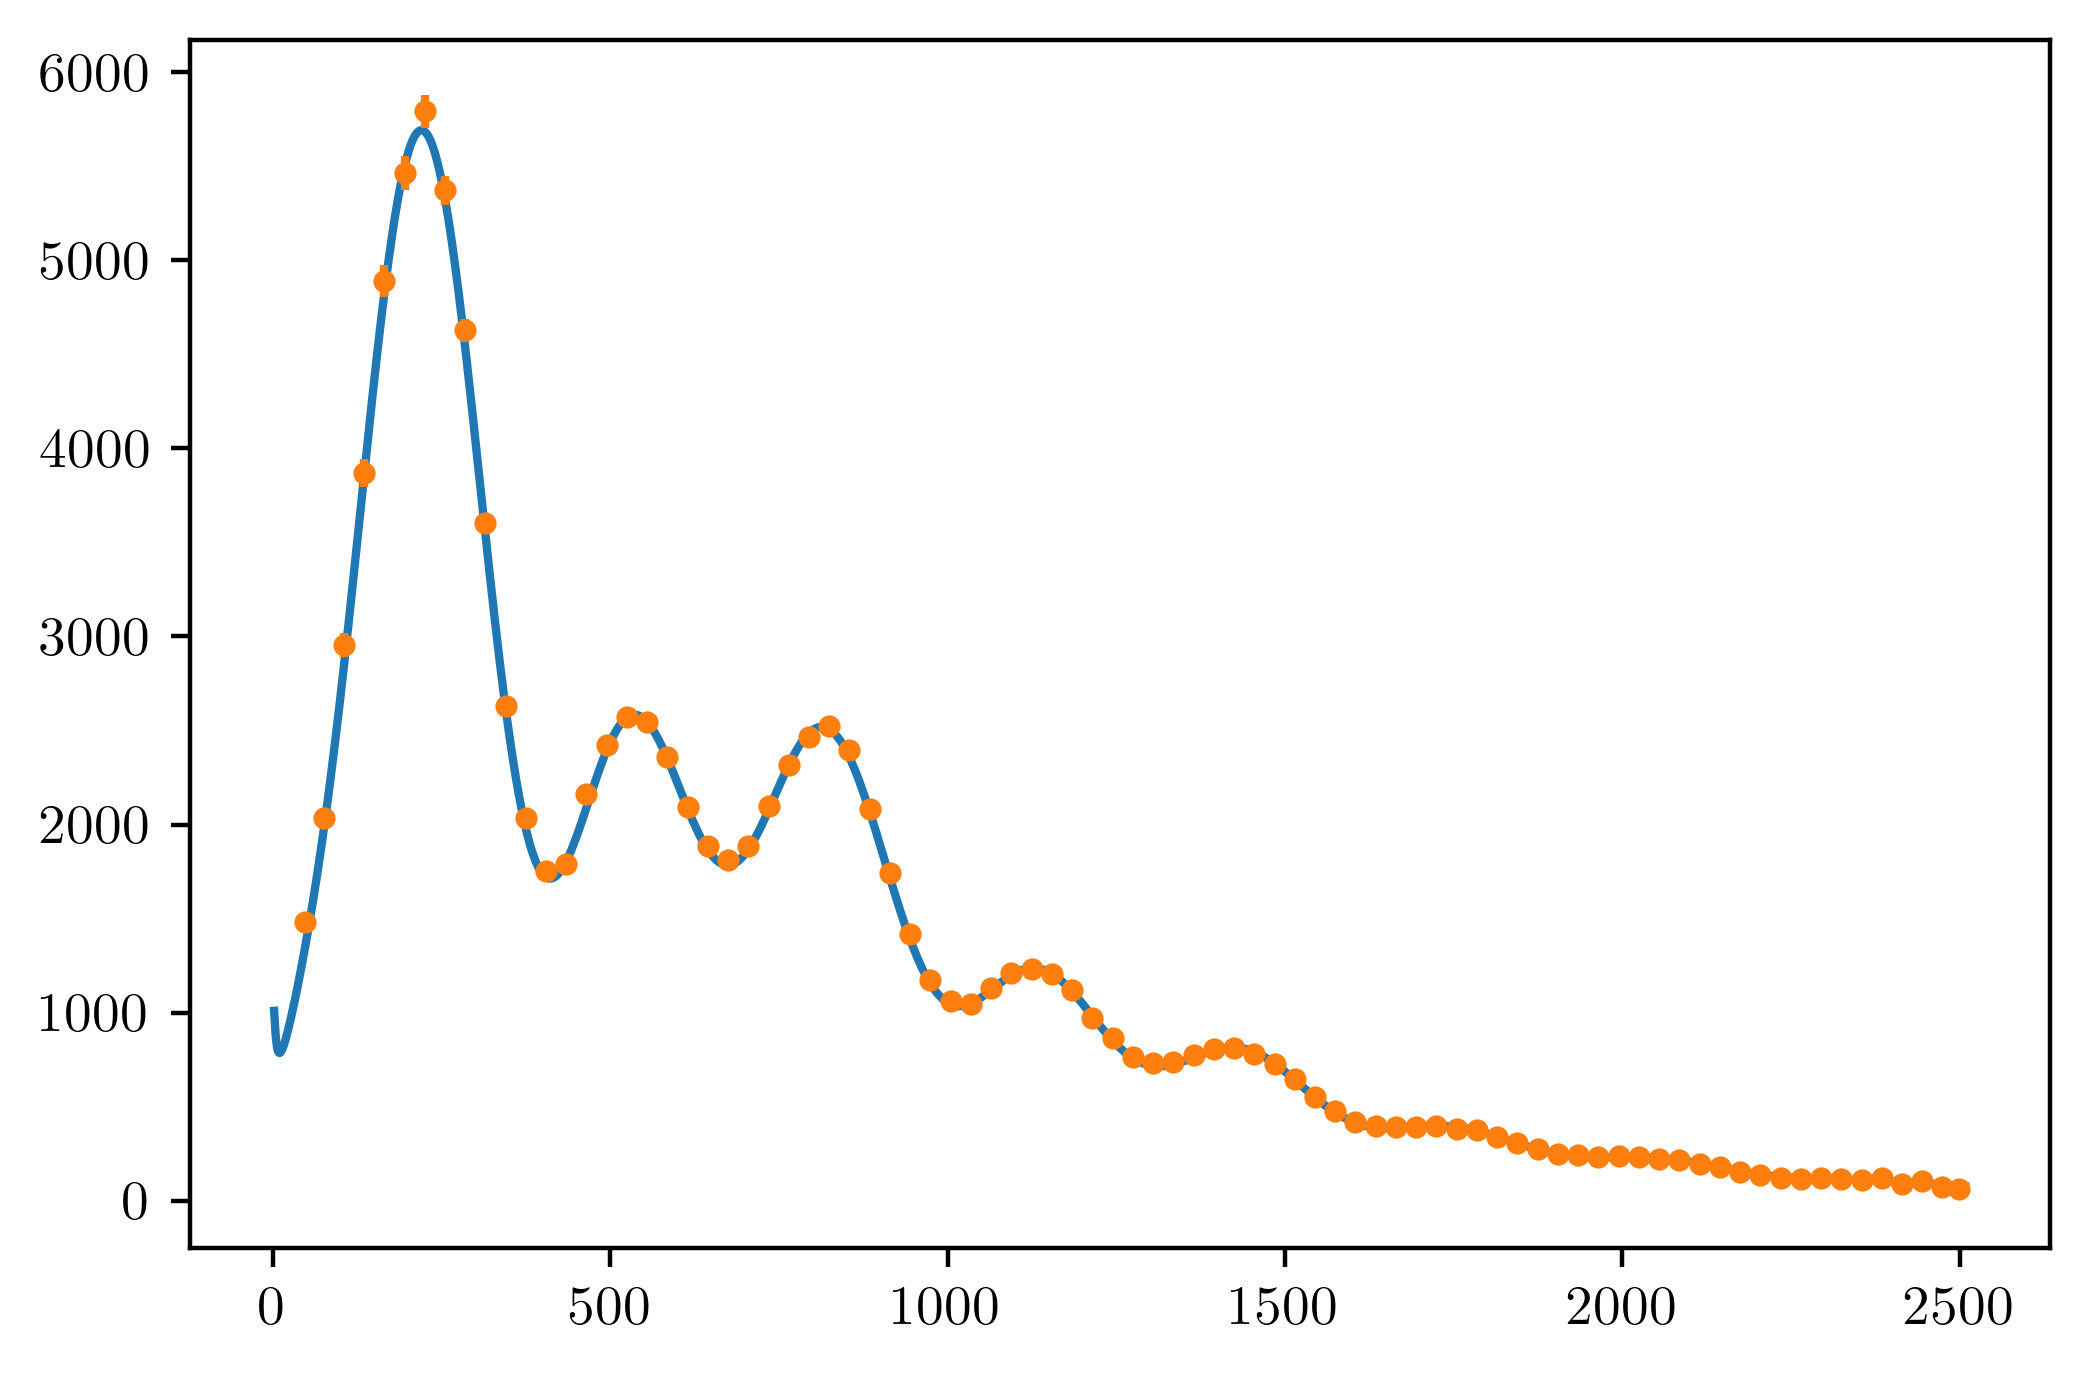

In [8]:
pars=m
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

Now we approximate the uncertainty on the fit parameters. We use the known errors on each data point of the power spectrum, and assume that all data points are uncorrelated.

In [9]:
# Calculating uncertainty on best fit parameters
Ninv = np.eye(errs.shape[0])*(1/errs)
cov = np.linalg.inv(A_m.T@Ninv@A_m)
    
# Printing uncertainty on best fit parameters
e_m = np.sqrt(np.diag(cov))
print(e_m)

[2.48305893e-02 1.62179403e-05 1.66412128e-05 2.57043190e-03
 1.08278865e-11 2.50016882e-04]


So the parameters and uncertainties we got via Newton's method are
\begin{align}
    H_0 &= (6.93\pm0.01)\text{x}10^1\\
    \Omega_bh^2 &=(2.262\pm0.002)\text{x}10^{-2}\\
    \Omega_ch^2 &=(1.154\pm0.002)\text{x}10^{-1}\\ 
    \tau &= (6.4\pm0.3)\text{x}10^{-2}\\
    A_s &= (2.10\pm0.01)\text{x}10^{-9}\\
    n_s &= (9.774\pm0.007)\text{x}10^{-1}
\end{align}
Now we just save it all to a file

In [10]:
with open('planck_fit_params.txt', 'w') as f:
    f.write('Quantity       Best fit value         uncertainty\n')
    f.write('H0             {}      {}\n'.format(m[0],e_m[0]))
    f.write('Omega_bh^2     {}      {}\n'.format(m[1],e_m[1]))
    f.write('Omega_ch^2     {}      {}\n'.format(m[2],e_m[2]))
    f.write('tau            {}      {}\n'.format(m[3],e_m[3]))
    f.write('A_s            {}      {}\n'.format(m[4],e_m[4]))
    f.write('n_s            {}      {}\n'.format(m[5],e_m[5]))

# Q3

Now we use an MCMC to estimate the parameters and uncertainties

In [15]:
# Function to make an MCMC chain
def chi2(pars,x,y,errs):
    model=get_spectrum(pars)
    model=model[:len(spec)]
    resid=y-model
    chisq=np.sum((resid/errs)**2)
    return chisq

def mcmc(pars,cov,x,y,fun,noise,nstep=1000):
    # Initial chi2
    chi_cur=fun(pars,x,y,noise)
    # Making array to hold chains and chi2
    npar=pars.shape[0]
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)

    for i in range(nstep):
        print(i)
        
        L = np.linalg.cholesky(cov)
        n = L@np.random.randn(6)    
        trial_pars=pars+n
        trial_chisq=fun(trial_pars,x,y,noise)
        delta_chisq=trial_chisq-chi_cur
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob
        if accept:
            pars=trial_pars
            chi_cur=trial_chisq
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec

In [54]:
pars = m
x = planck[:,0]
y = planck[:,1]
fun = chi2
noise = 0.5*(planck[:,2]+planck[:,3])

chain,chivec = mcmc(pars,cov,x,y,fun,noise,nstep=10)
with open('planck_chain.txt', 'w') as f:
    f.write('H0                  Omega_bh^2           Omega_ch^2          tau                   A_s                  n_s\n')
    for i in range(chain.shape[0]):
        f.write('{} {} {} {} {} {}\n'.format(chain[i,0],chain[i,1],chain[i,2],chain[i,3],chain[i,4],chain[i,5]))


0
1
2
3
4
5
6
7
8
9


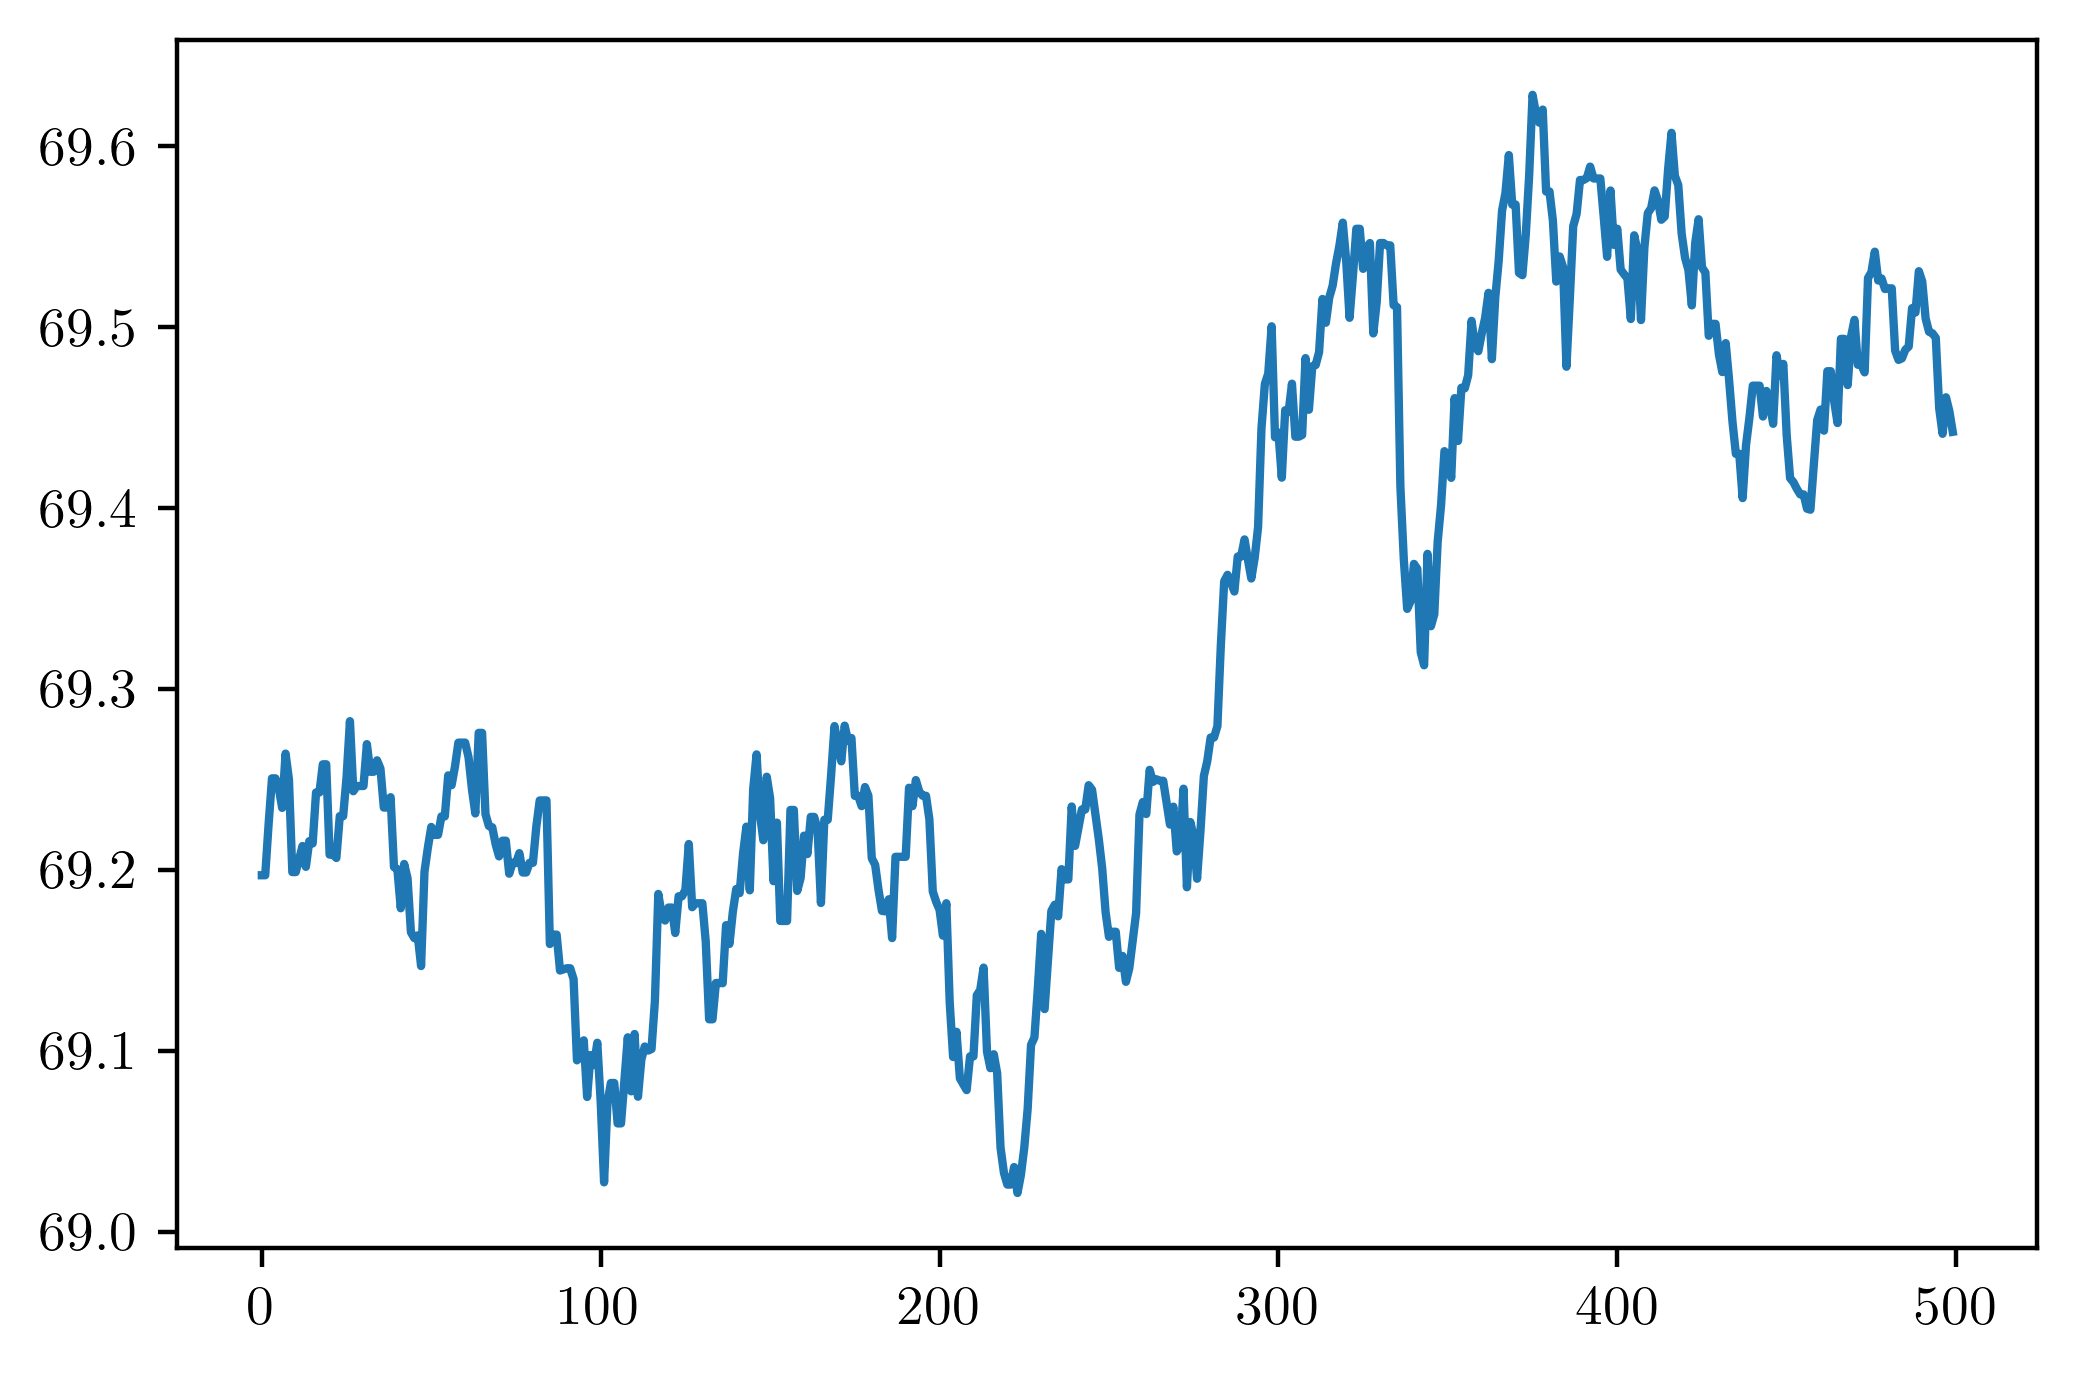

In [17]:
plt.plot(chain[:,0])

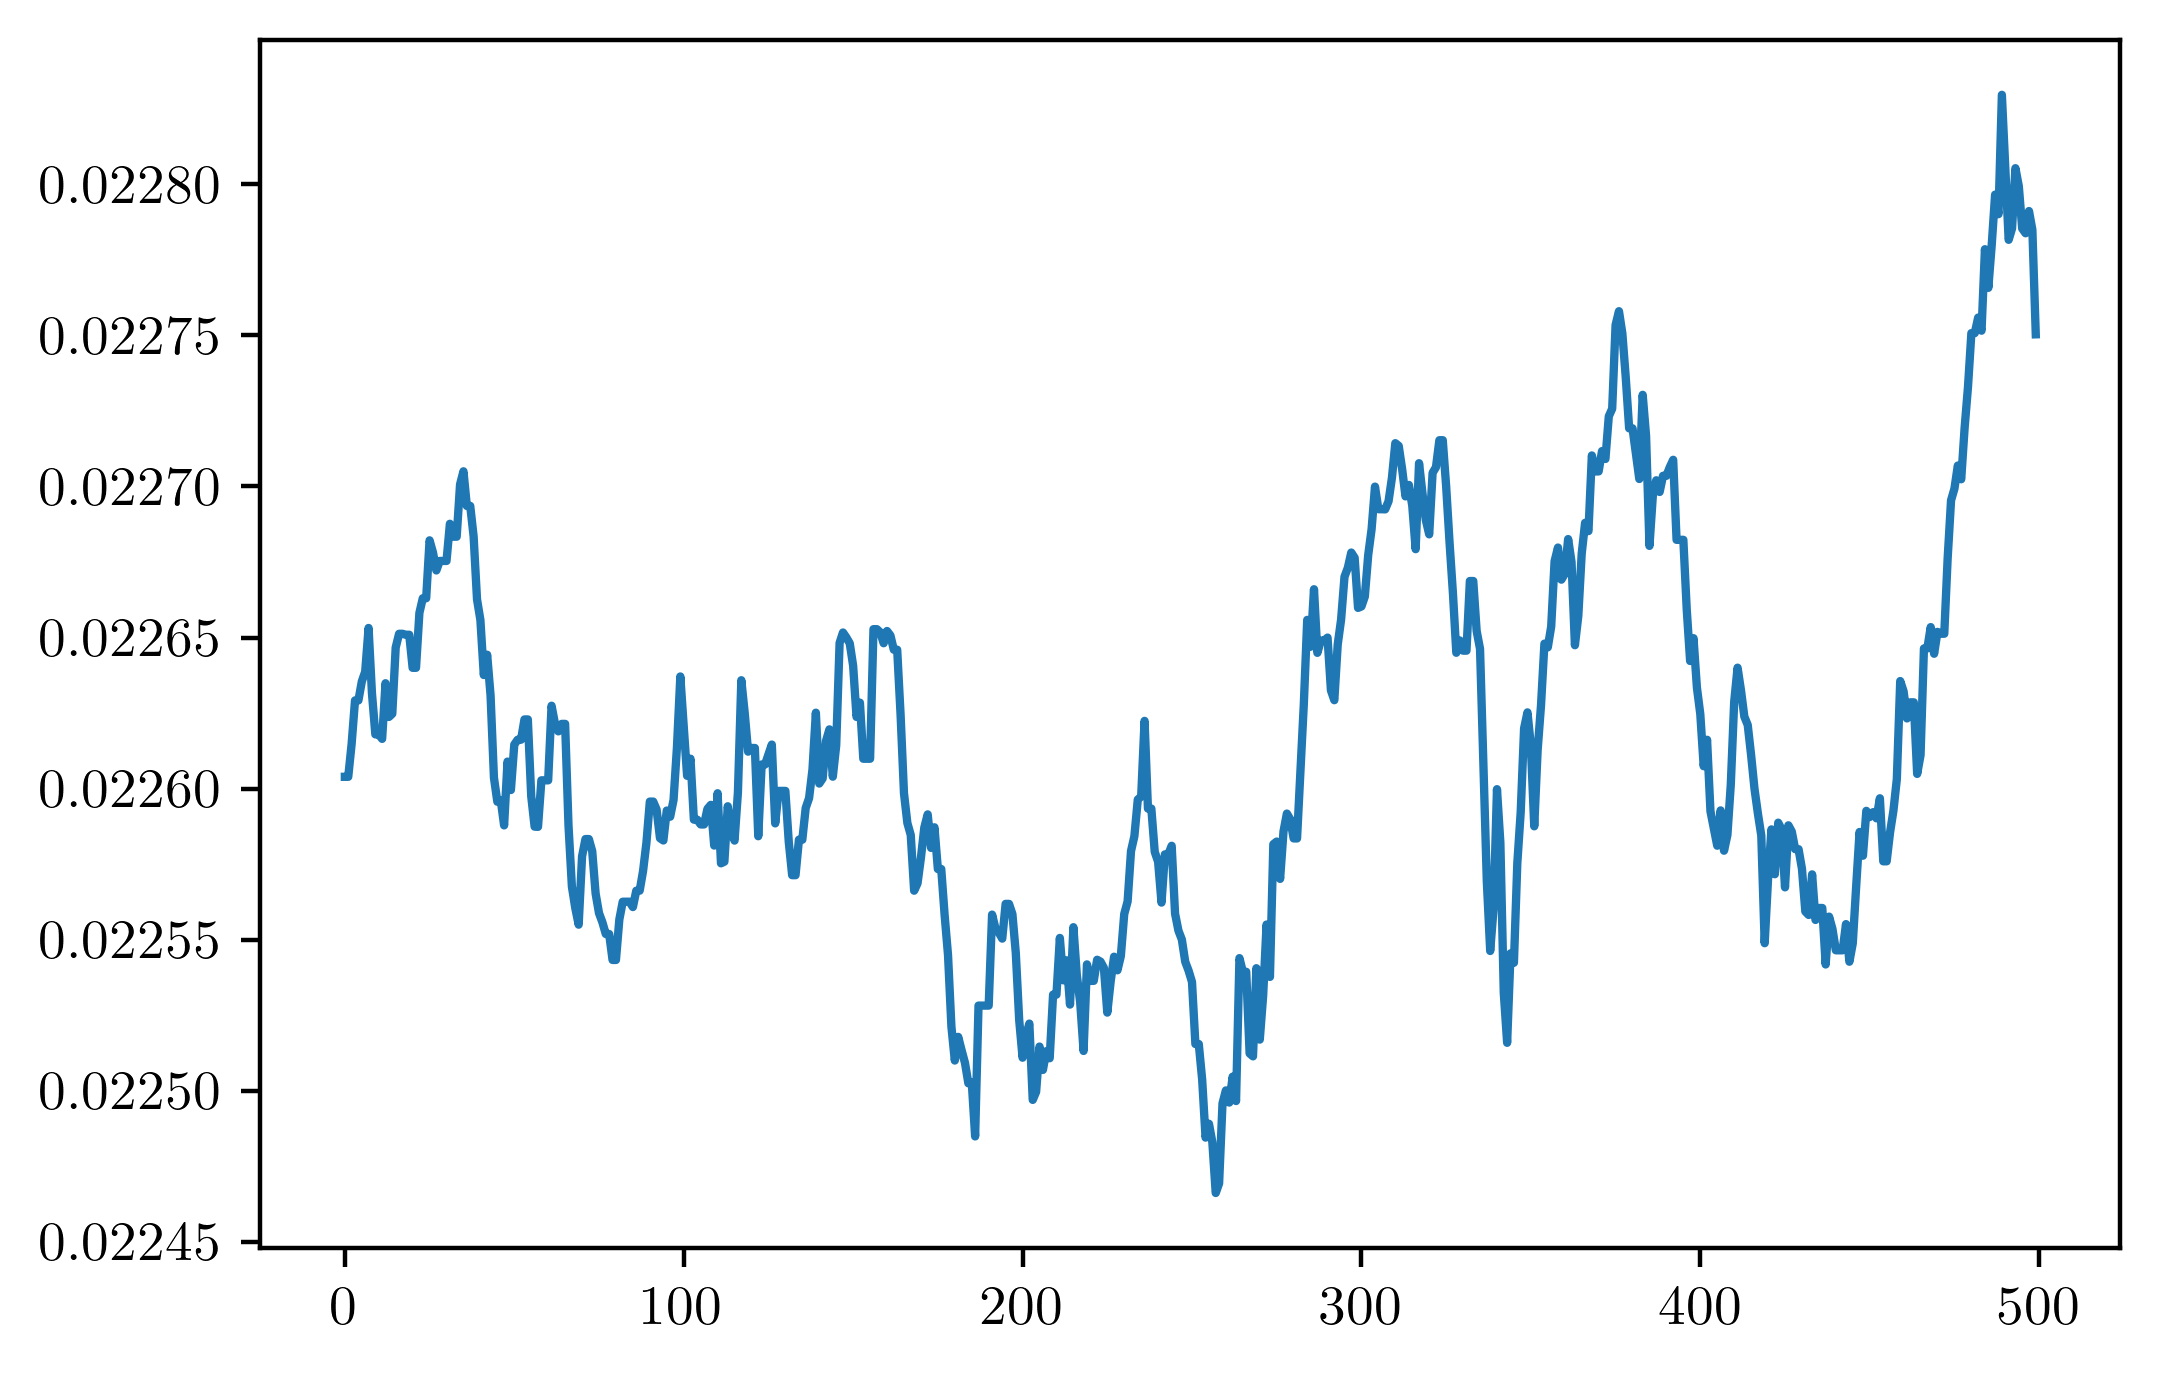

In [18]:
plt.plot(chain[:,1])

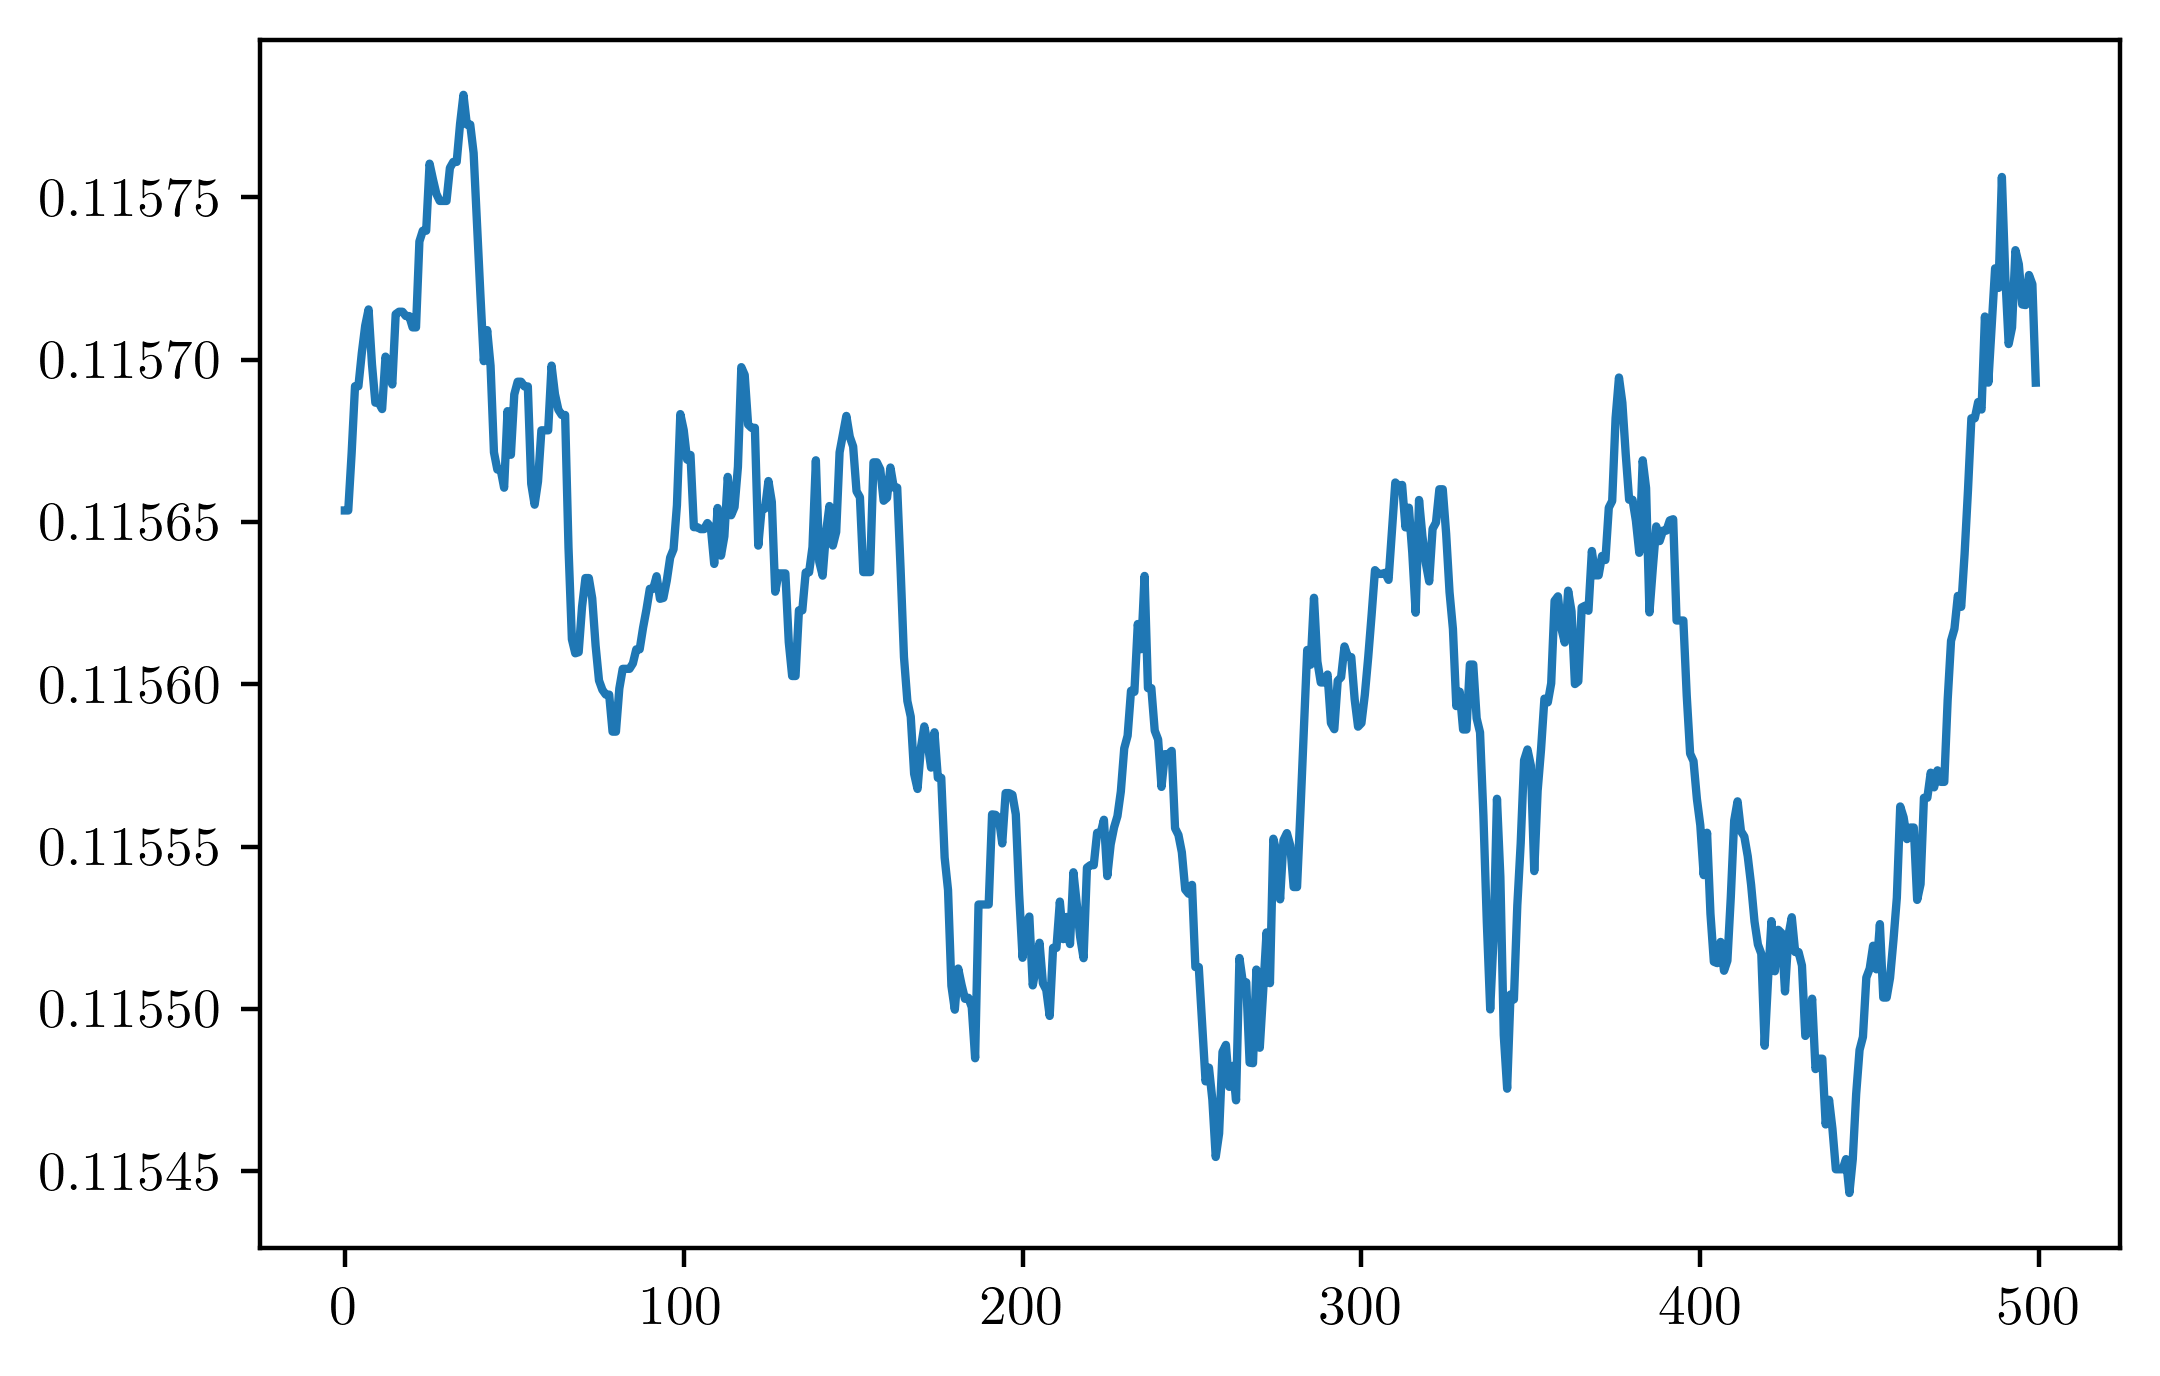

In [19]:
plt.plot(chain[:,2])

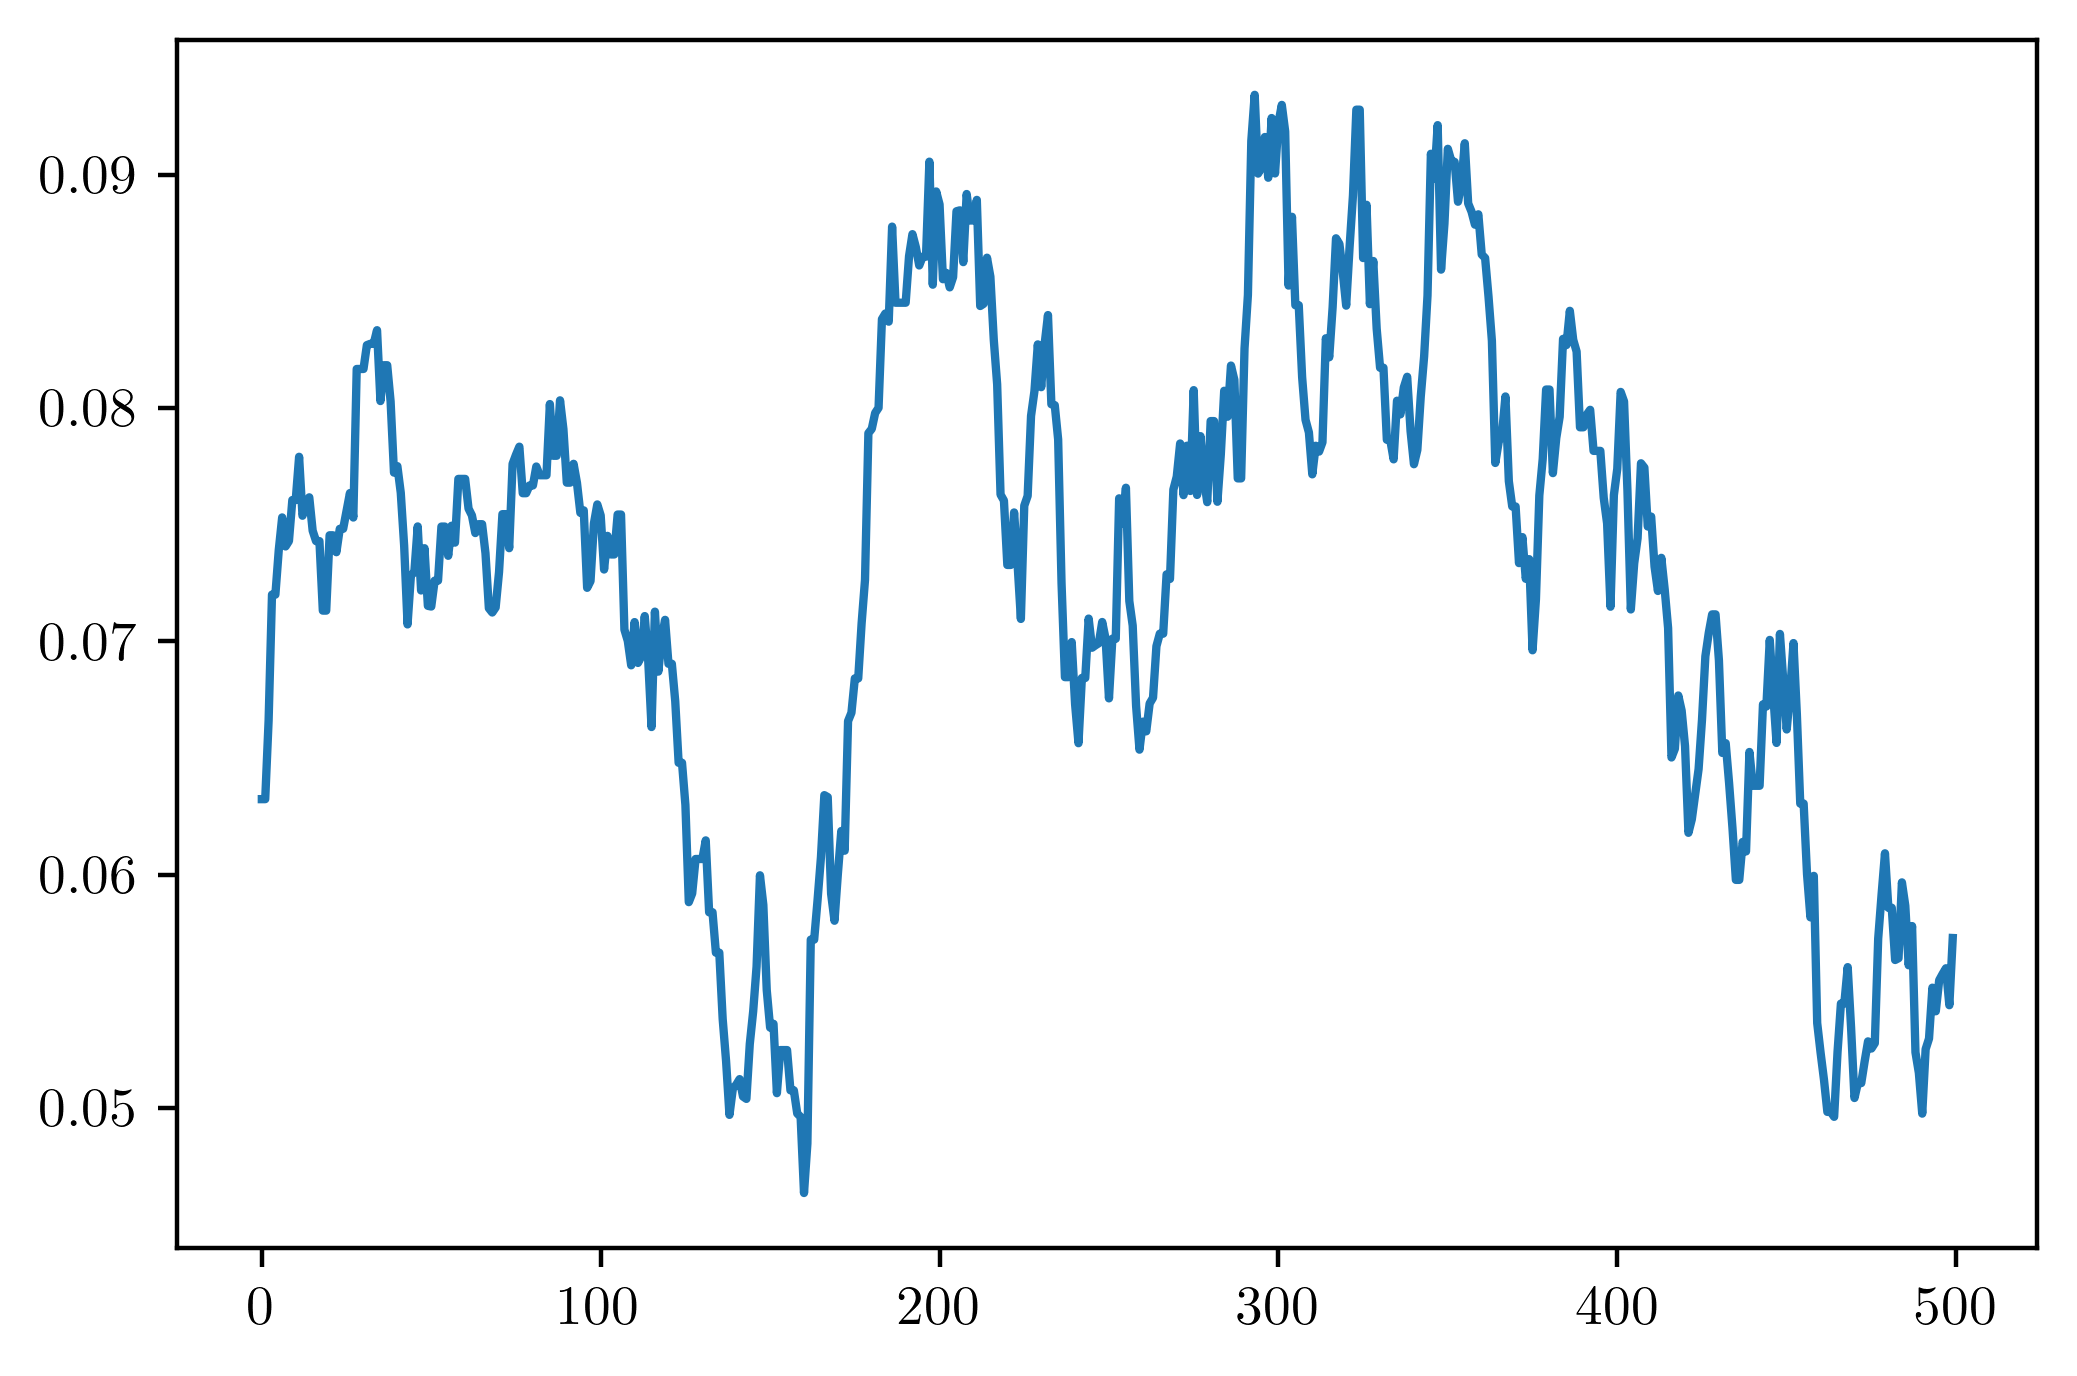

In [20]:
plt.plot(chain[:,3])

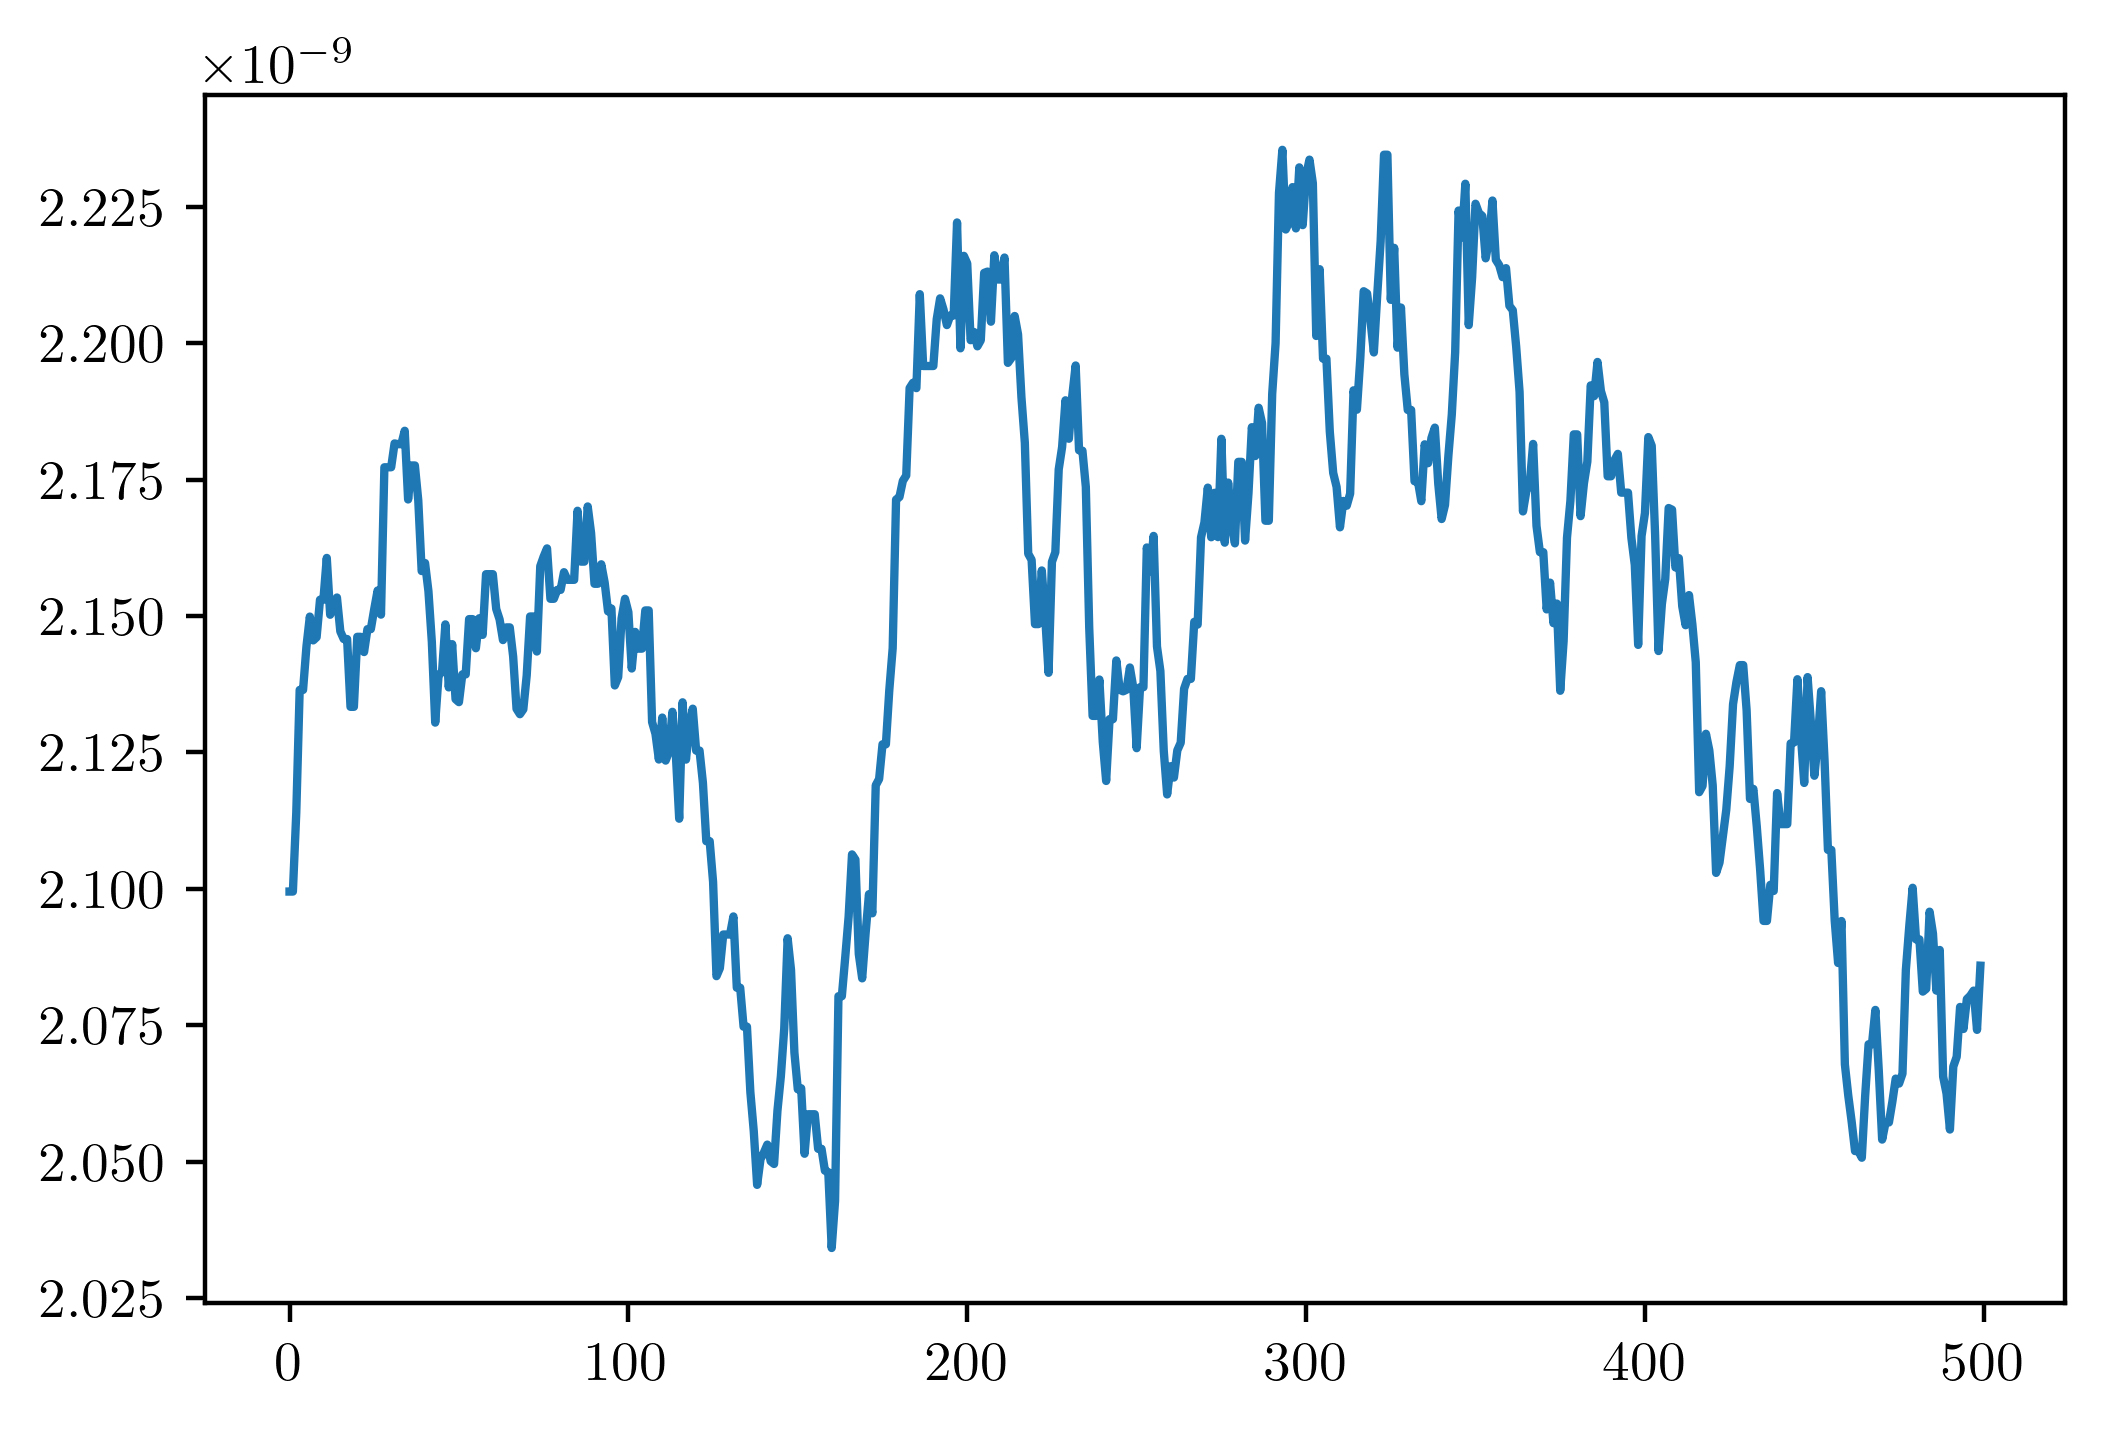

In [42]:
plt.plot(chain[:,4])

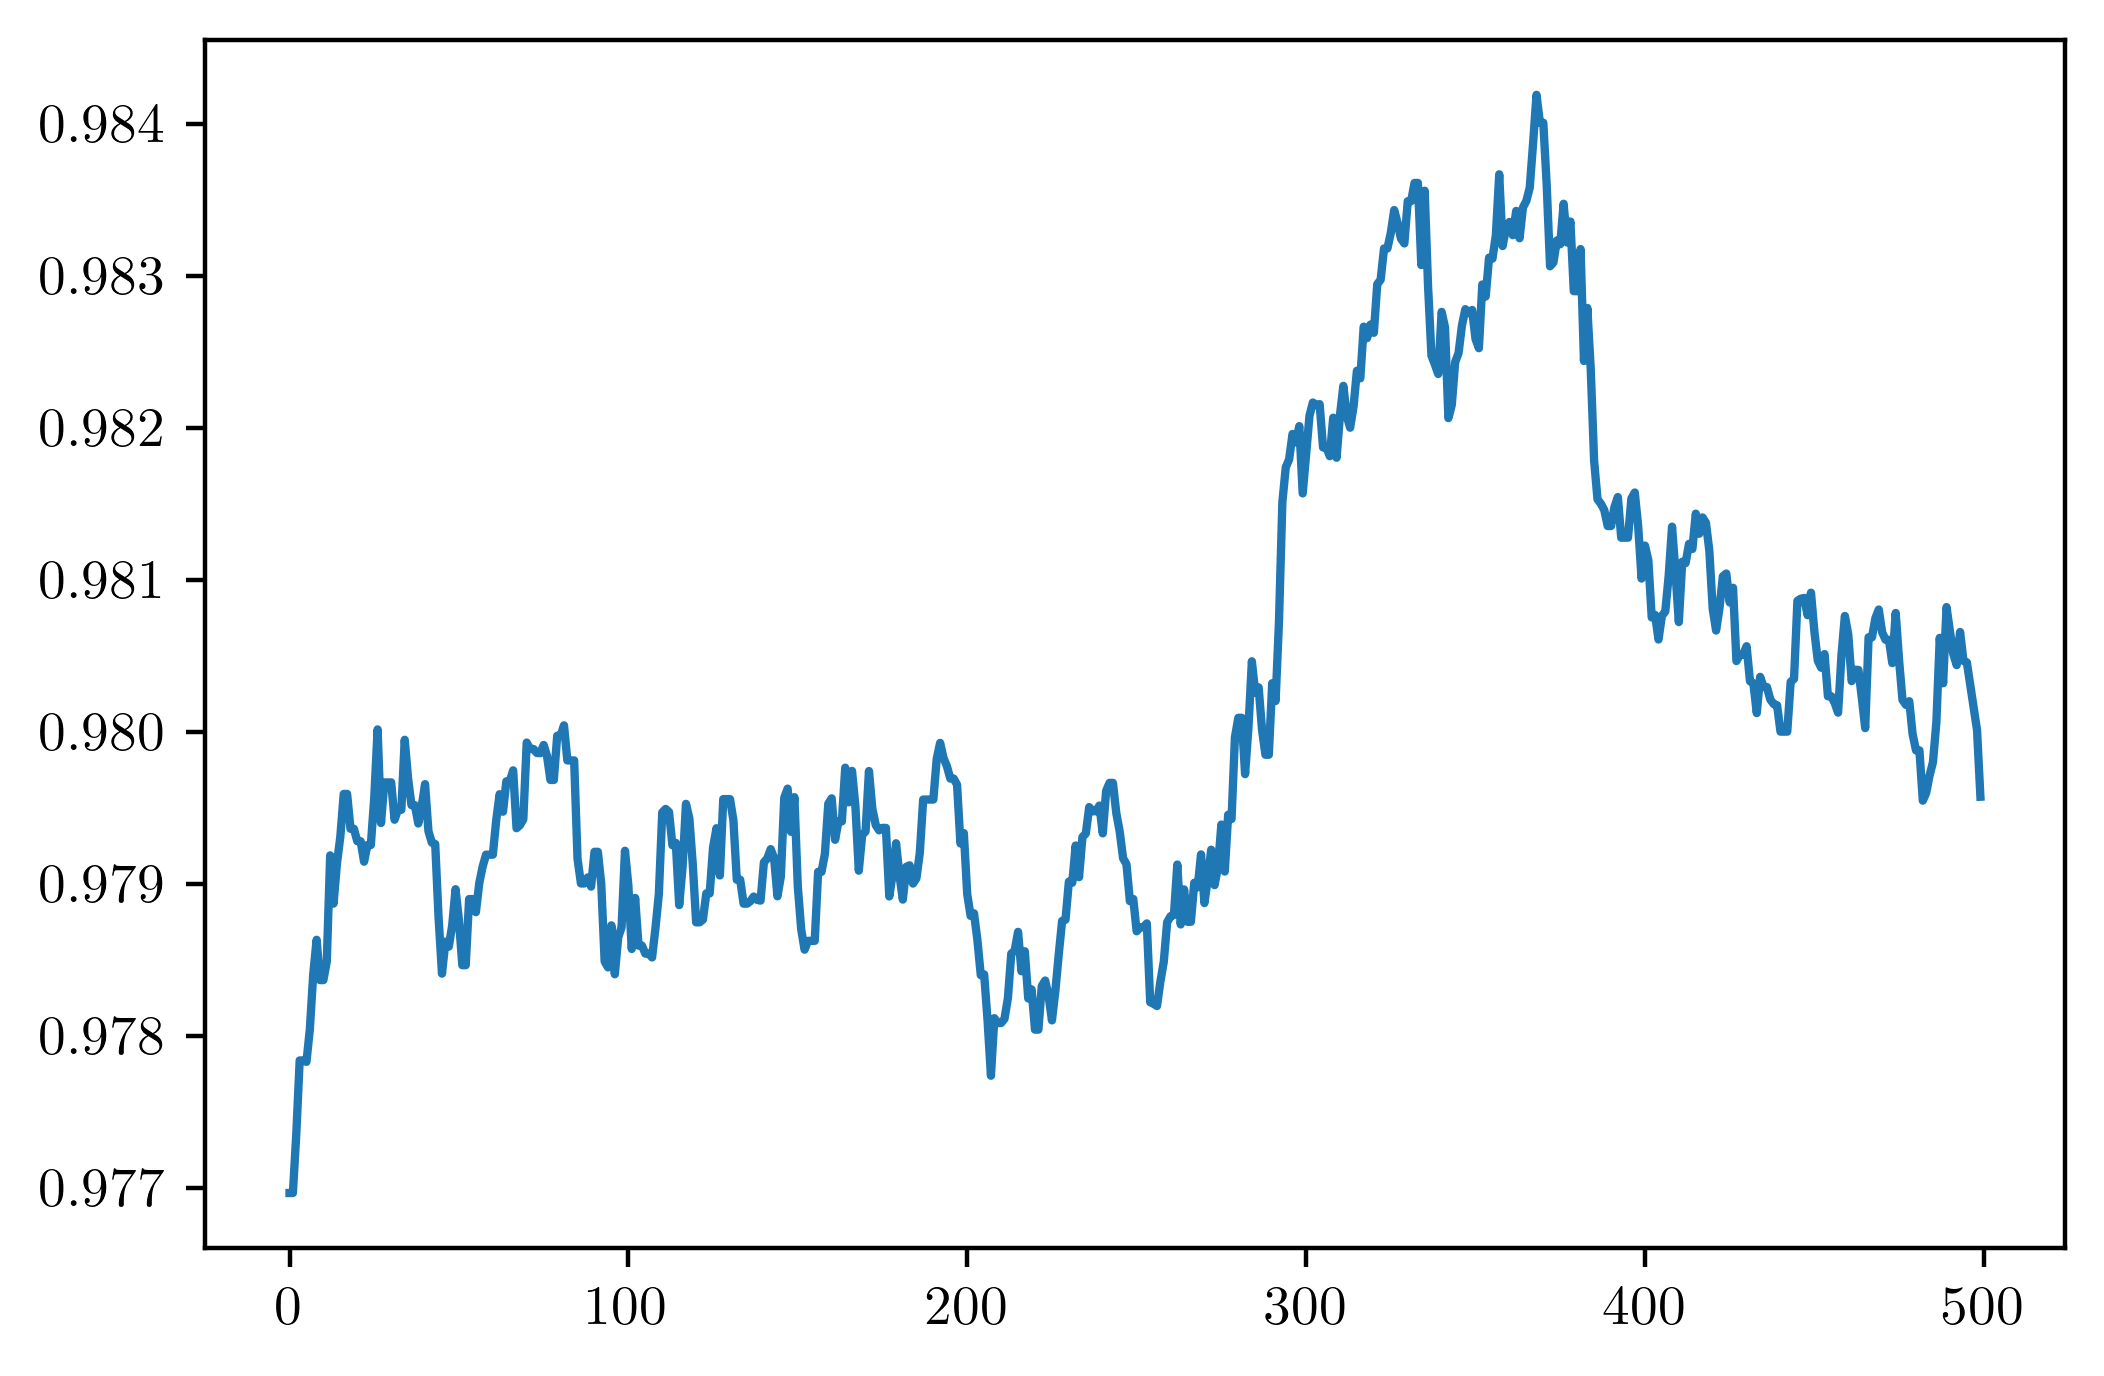

In [22]:
plt.plot(chain[:,5])

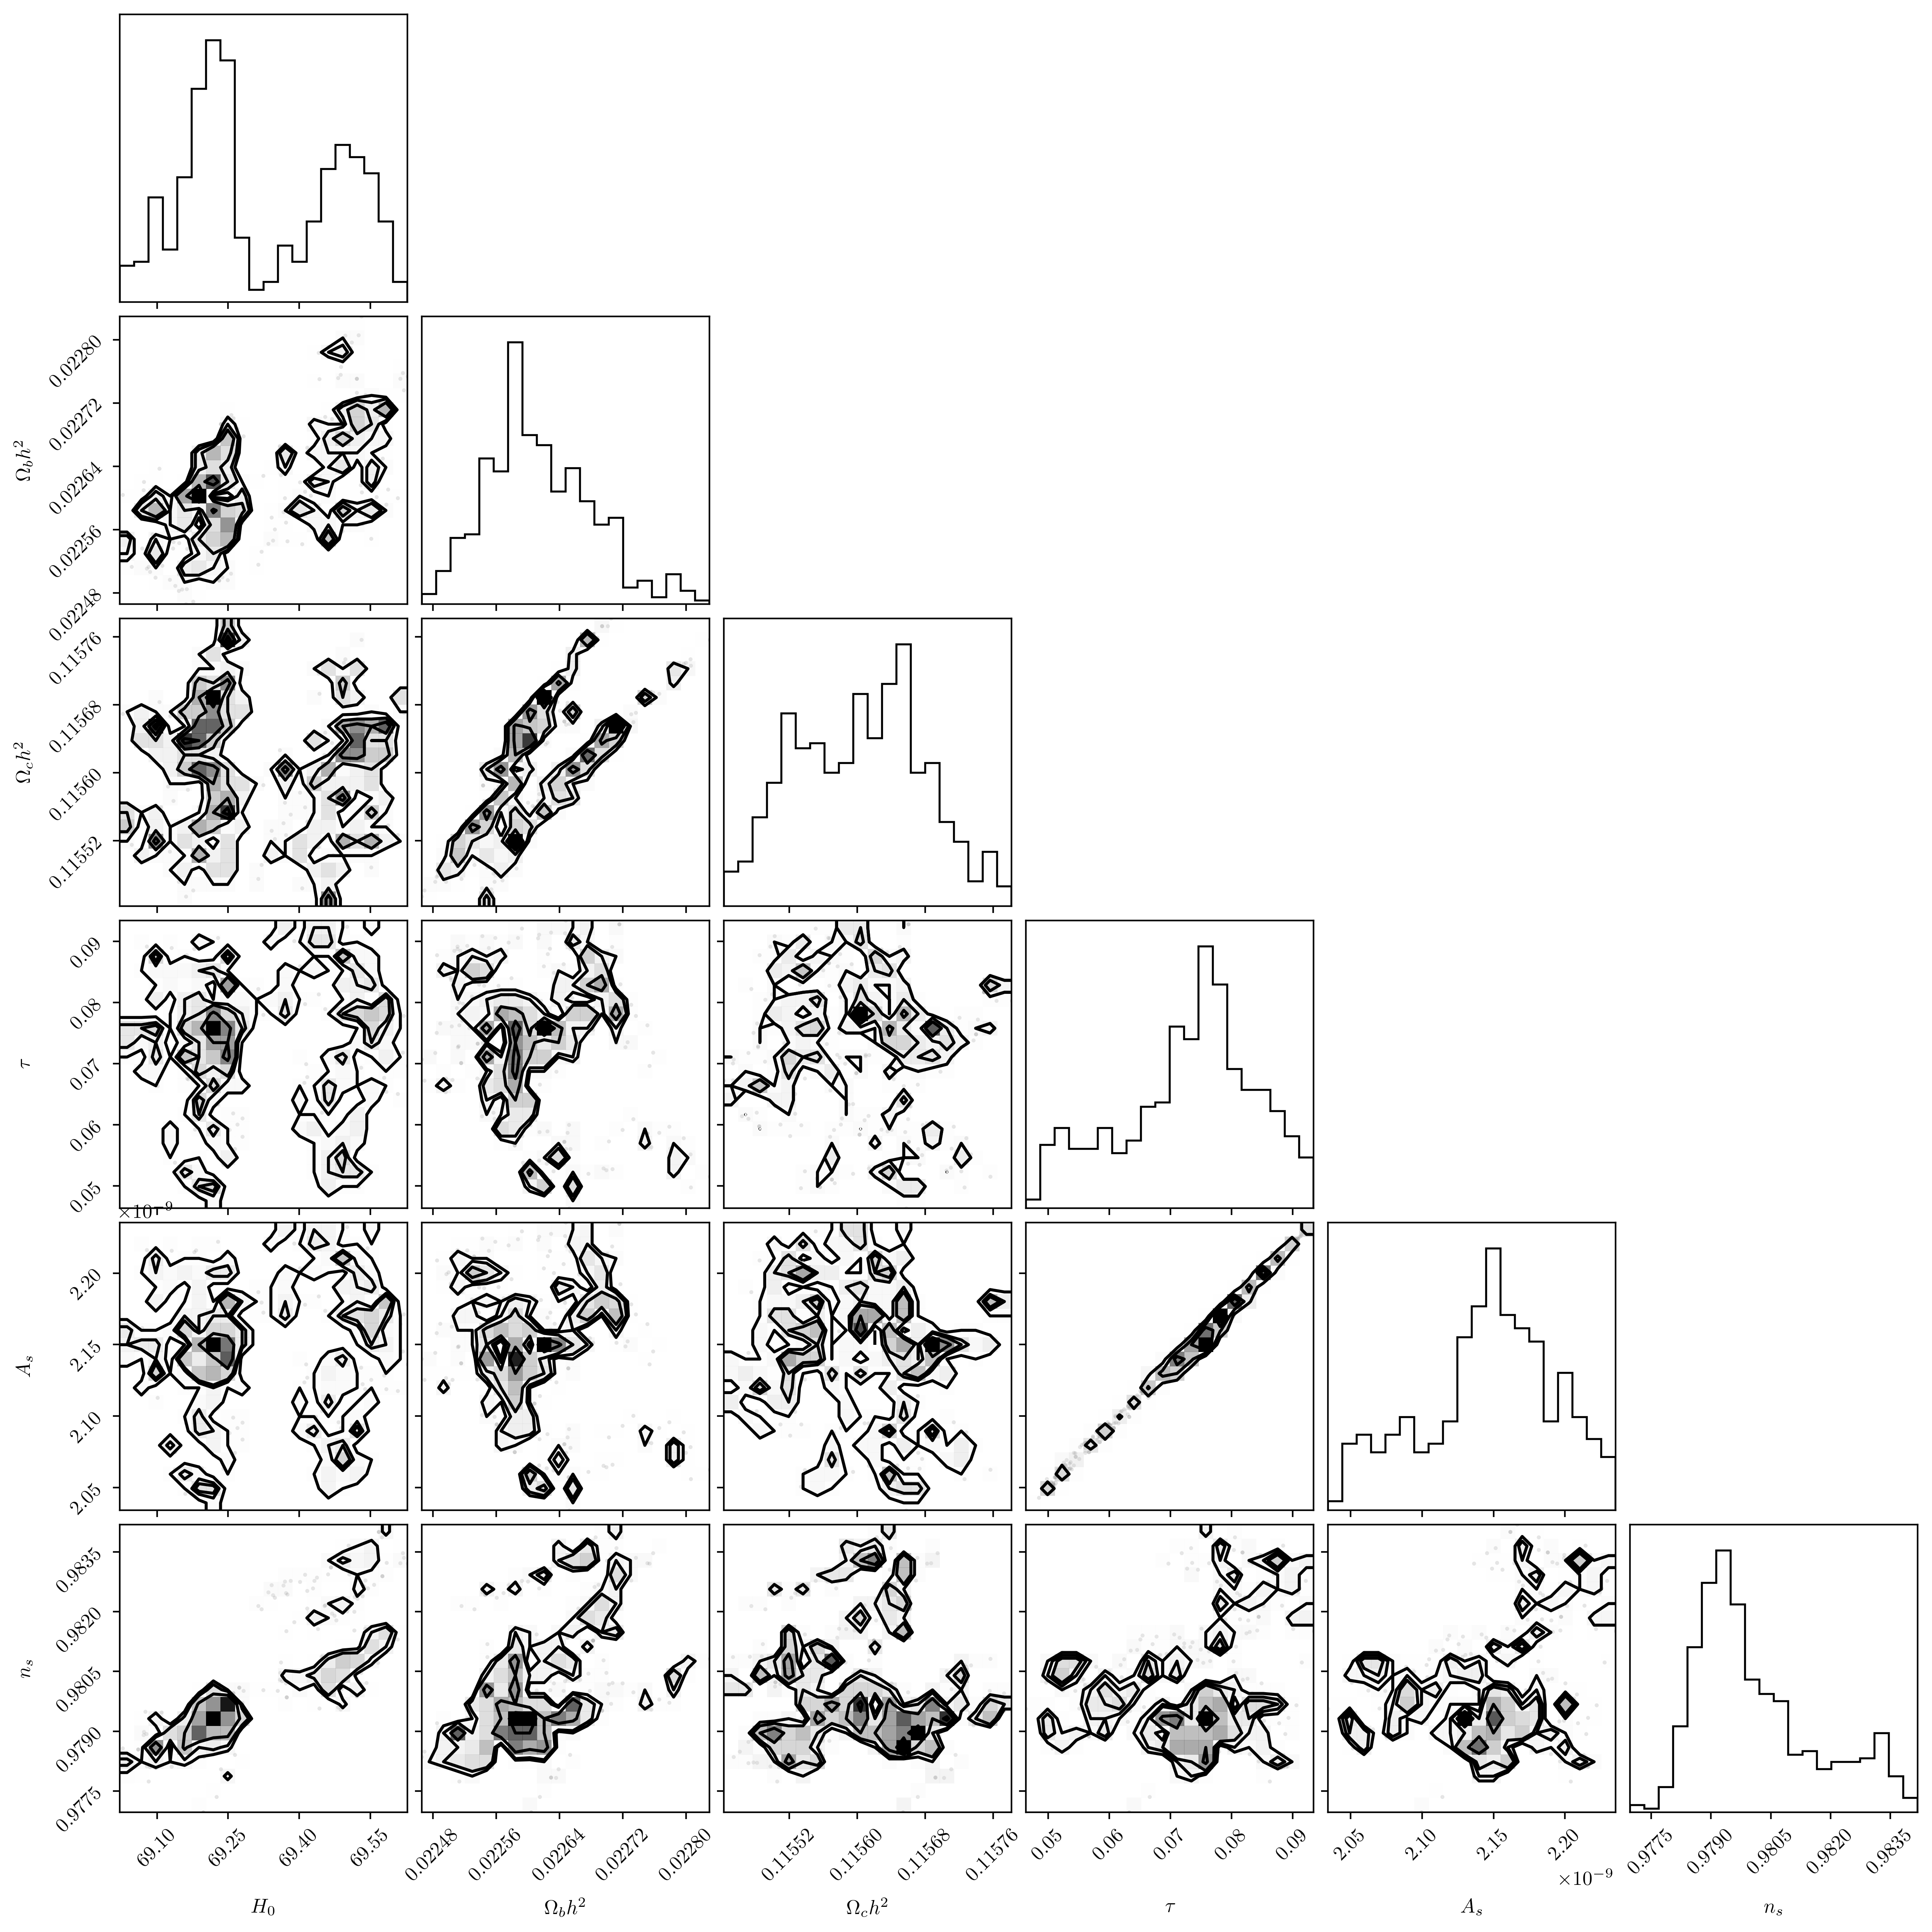

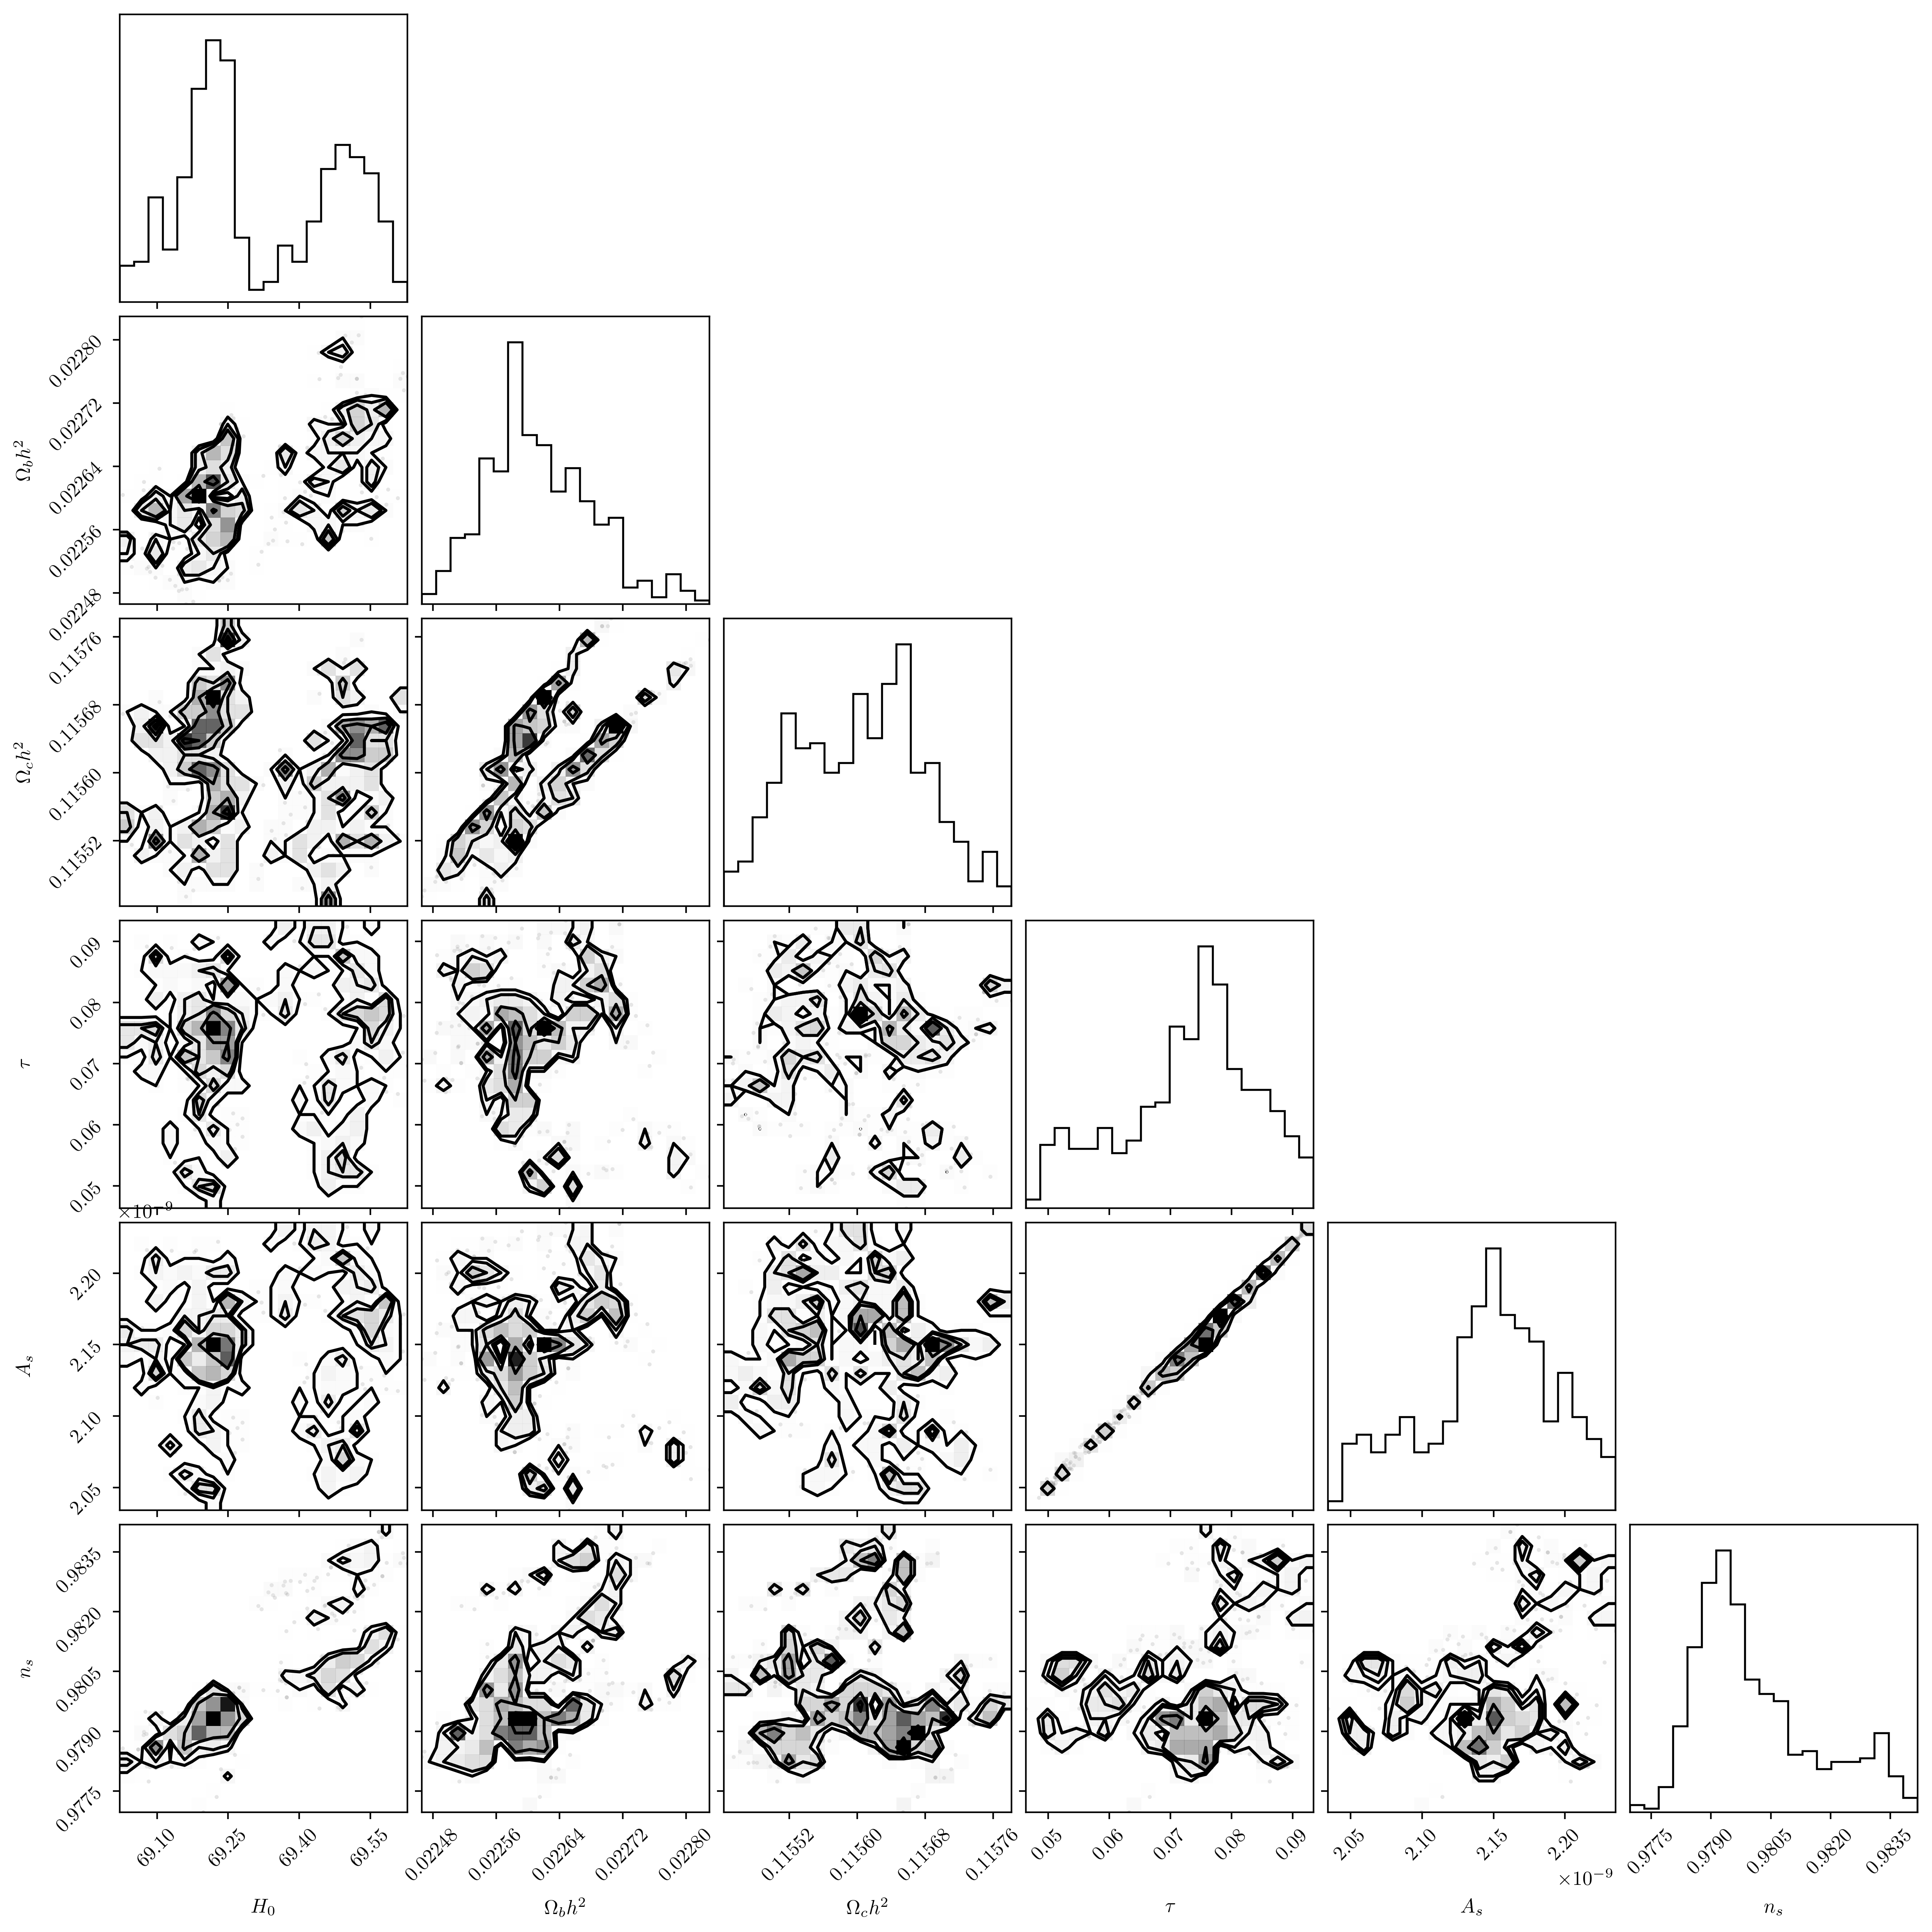

In [35]:
corner.corner(chain,
             labels=['$H_0$',
                     '$\Omega_b h^2$',
                     '$\Omega_c h^2$',
                     '$\\tau$',
                     '$A_s$',
                     '$n_s$'])

Now we calculate the parameters and uncertainties from the chain

In [43]:
H_0 = np.mean(chain[:,0])
e_H_0 = np.std(chain[:,0])
print(H_0,e_H_0)

Omega_b = np.mean(chain[:,1])
e_Omega_b = np.std(chain[:,1])
print(Omega_b,e_Omega_b)

Omega_c = np.mean(chain[:,2])
e_Omega_c = np.std(chain[:,2])
print(Omega_c,e_Omega_c)

tau = np.mean(chain[:,3])
e_tau = np.std(chain[:,3])
print(tau,e_tau)

A_s = np.mean(chain[:,4])
e_A_s = np.std(chain[:,4])
print(A_s,e_A_s)

n_s = np.mean(chain[:,5])
e_n_s = np.std(chain[:,5])
print(n_s,e_n_s)

69.31969684757418 0.16168347431573926
0.022614810921098433 6.694932843523134e-05
0.1156036376716589 7.383431594249413e-05
0.07291697769494894 0.01083645656779479
2.1465527964182983e-09 4.579947494598368e-11
0.9801441516601246 0.0015145321568250667


So the parameters and uncertainties we got are
\begin{align}
    to do
\end{align}
todo: explains why chains are converged.

Now we calculate the energy density of dark energy

In [47]:
Omega_lambda = 1 - Omega_b/(H_0/100) - Omega_c/(H_0/100)
e_Omega_lambda = (e_Omega_b/Omega_b+e_H_0/H_0)*(Omega_b/(H_0/100)) + (e_Omega_c/Omega_c+e_H_0/H_0)*(Omega_c/(H_0/100))

print(Omega_lambda,e_Omega_lambda)

0.800607251793551 0.0006681632901973006


So are MCMC gives that the energy density of Dark Energy is
\begin{align}
    \Omega_{\Lambda} = 0.8006 \pm 0.0007
\end{align}